# CS145 Introduction to Data Mining - Assignment 2
## Deadline: 12:00PM (noon), April 19, 2024

## Instructions
Each assignment is structured as a Jupyter notebook, offering interactive tutorials that align with our lectures. You will encounter two types of problems: *write-up problems* and *coding problems*.

1. **Write-up Problems:** These problems are primarily theoretical, requiring you to demonstrate your understanding of lecture concepts and to provide mathematical proofs for key theorems. Your answers should include sufficient steps for the mathematical derivations.
2. **Coding Problems:** Here, you will be engaging with practical coding tasks. These may involve completing code segments provided in the notebooks or developing models from scratch.

To ensure clarity and consistency in your submissions, please adhere to the following guidelines:

* For write-up problems, use Markdown bullet points to format text answers. Also, express all mathematical equations using $\LaTeX$ and avoid plain text such as `x0`, `x^1`, or `R x Q` for equations.
* For coding problems, comment on your code thoroughly for readability and ensure your code is executable. Non-runnable code may lead to a loss of **all** points. Coding problems have automated grading, and altering the grading code will result in a deduction of **all** points.
* Your submission should show the entire process of data loading, preprocessing, model implementation, training, and result analysis. This can be achieved through a mix of explanatory text cells, inline comments, intermediate result displays, and experimental visualizations.

### Collaboration and Integrity

* Collaboration is encouraged, but all final submissions must be your own work. Please acknowledge any collaboration or external sources used, including websites, papers, and GitHub repositories.
* Any suspicious cases of academic misconduct will be reported to The Office of the Dean of Students.

## Before You Start

Useful information about managing environments can be found [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).

You may also quickly review the usage of basic Python and Numpy package, if needed in coding for matrix operations.

In this notebook, you must not delete any code cells in this notebook. If you change any code outside the blocks that you are allowed to edit (between `STRART/END YOUR CODE HERE`), you need to highlight these changes. You may add some additional cells to help explain your results and observations.

## Part 1: Multilayer Perceptrons and Backpropagation

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Problem 1 (10 points)

Implement the `gradient` of Sigmoid and ReLU activation functions.
The `Activation` class is designed to accomodate various activation functions. Explain its functionality: why the `update` function is empty and why the `backward` function is implemented this way?

In [2]:
class Sigmoid:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        x = 1 / (1 + np.exp(-x))
        return x * (1 - x)


class ReLU:
    def forward(self, x):
        return np.maximum(0, x)

    def gradient(self, x):
        return np.where(x >= 0, 1, 0)


class Activation:
    """
    Wrapper layer for activation functions.
    """
    def __init__(self, act, name="activation"):
        self.activation = act.forward
        self.activation_gradient = act.gradient
        self.input = None
        self.name = name
        self.output = None

    def forward(self, x):
        self.input = x
        self.output = self.activation(x)
        return self.output

    def backward(self, output_error):
        return self.activation_gradient(self.input) * output_error

    def update(self, *args, **kwargs):
        pass

    def __call__(self, x):
        return self.forward(x)

In [3]:
print('Testing Sigmoid gradient...')
x = np.array([-2, -1, 0, 1, 2]).reshape(-1, 1)
s = Sigmoid()
expected_output = np.array([[0.10499359], [0.19661193], [0.25], [0.19661193], [0.10499359]])
assert np.allclose(s.gradient(x), expected_output), 'Sigmoid gradient test failed'
print('Sigmoid gradient test passed!')

Testing Sigmoid gradient...
Sigmoid gradient test passed!


In [4]:
print('Testing ReLU gradient...')
x = np.array([-2, -1, 1, 2]).reshape(-1, 1)
r = ReLU()
expected_output = np.array([[0], [0], [1], [1]])
assert np.allclose(r.gradient(x), expected_output), 'ReLU gradient test failed'
print('ReLU gradient test passed!')

Testing ReLU gradient...
ReLU gradient test passed!


In [5]:
print('Testing Activation backward...')
x = np.array([-2, -1, 1, 2]).reshape(-1, 1)
a = Activation(ReLU())
out = a(x)
output_error = np.array([0.1, 0.2, 0.4, 0.5]).reshape(-1, 1)
expected_output = np.array([[0.], [0.], [0.4], [0.5]])
assert np.allclose(a.backward(output_error), expected_output), 'Activation backward test failed'
print('Activation backward test passed!')

Testing Activation backward...
Activation backward test passed!


Answer:

The update function in the Activation layer is empty because activation layers typically do not have any learnable parameters to update. The backward function simply computes the gradient of the activation function with respect to its input and multiplies it element-wise with the gradient passed from the next layer (gradient_loss_to_output). This is due to the chain rule of differentiation.

### Problem 2 (10 points)

Given the following network, please derive the gradient of the loss with respect to the input $\frac{\mathrm{d}l}{\mathrm{d}x} \in \mathbb{R}^{n\times d}$.
You may find [this](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) matrix cookbook useful.

$$
\begin{align}
    \boldsymbol{Z} &= \boldsymbol{X} + \operatorname{sigmoid}(\boldsymbol{XW}), \\
    \hat{\boldsymbol{y}} &= \frac{1}{d}\sum_{j=1}^d \boldsymbol{Z}_{:,j} = \frac{1}{d} \boldsymbol{Z} \boldsymbol{1}_d, \\
    l &= \frac{1}{n} \sum_{i=1}^n (\boldsymbol{y}_i - \hat{\boldsymbol{y}}_i)^2,
\end{align}
$$

where $\boldsymbol{X}, \boldsymbol{Z} \in \mathbb{R}^{n \times d}$, $\boldsymbol{1}_d$ is an all-one column vector of dimension $d$, $\boldsymbol{W} \in \mathbb{R}^{d \times d}$, and $\hat{\boldsymbol{y}}, \boldsymbol{y} \in \mathbb{R}^{n}$.

Here is a code snippet to help you understand the network structure:

```python
class SimpleNetwork:
    def __init__(self, d):
        self.W = np.random.randn(d, d)
    
    def forward(self, X):
        self.Z = X + sigmoid(np.dot(X, self.W))
        y_pred = np.mean(self.Z, axis=1)
        return y_pred
    
    def loss(self, X, y):
        y_pred = self.forward(X)
        return ((y - y_pred) ** 2).mean()
```

Answer:

Since each $\boldsymbol{Z}_i$ is only related to $\boldsymbol{X}_i$, $\mathrm{d}\boldsymbol{Z}_i / \mathrm{d}\boldsymbol{X}_j = 0$. We can start with
$$
\frac{\mathrm{d} \boldsymbol{Z}_i}{\mathrm{~d} \boldsymbol{X}_i}=\boldsymbol{I}_d+\operatorname{diag}\left(\sigma^{\prime}\left(\boldsymbol{X}_i \boldsymbol{W}\right)\right) \boldsymbol{W}^{\mathrm{T}}.
$$
Then, according to the chain rule, we have
$$
\begin{align}
\frac{\mathrm{d} \boldsymbol{l}}{\mathrm{d} \boldsymbol{X}_i} & =\frac{\mathrm{d} l}{\mathrm{~d} \widehat{\boldsymbol{y}}} \cdot \frac{\mathrm{d} \widehat{\boldsymbol{y}}}{\mathrm{d} \boldsymbol{Z}_i} \cdot \frac{\mathrm{d} \boldsymbol{Z}_i}{\mathrm{~d} \boldsymbol{X}_i} \\
& =\frac{2}{n}(\widehat{\boldsymbol{y}}-\boldsymbol{y})^{\mathrm{T}} \cdot \frac{1}{d} \boldsymbol{J}_d \cdot\left(\boldsymbol{I}_d+\operatorname{diag}\left(\sigma^{\prime}\left(\boldsymbol{X}_i \boldsymbol{W}\right)\right) \boldsymbol{W}^{\mathrm{T}}\right) \\
& =\frac{2}{n d}\left(\hat{y}_i-y_i\right) \mathbf{1}_d^{\mathrm{T}} \cdot\left(\boldsymbol{I}_d+\operatorname{diag}\left(\sigma^{\prime}\left(\boldsymbol{X}_i \boldsymbol{W}\right)\right) \boldsymbol{W}^{\mathrm{T}}\right) \\
& =\frac{2}{n d}\left(\hat{y}_i-y_i\right)\left(\mathbf{1}_d^{\mathrm{T}}+\sigma\left(\boldsymbol{X}_i \boldsymbol{W}\right) \odot\left(1-\sigma\left(\boldsymbol{X}_i \boldsymbol{W}\right)\right) \boldsymbol{W}^{\mathrm{T}}\right).
\end{align}
$$
Here, $\boldsymbol{J}_d$ is a $(n \times d)$ matrix where the $d$-th row is all ones and zeros otherwise, $\mathbf{1}_d$ is an all one column vector of size $d$, and $\mathbf{I}_d$ is a $(d \times d)$ matrix whose diagonal entries are ones and zeros otherwise.

Finally, we stack all $\mathrm{d}l/\mathrm{d}\boldsymbol{X}_i$'s to form a matrix
$$
\frac{\mathrm{d} l}{\mathrm{~d} \boldsymbol{X}}=\frac{2}{n d}\left((\hat{\boldsymbol{y}}-\boldsymbol{y}) \mathbf{1}_d^{\mathrm{T}}+\operatorname{diag}(\hat{\boldsymbol{y}}-\boldsymbol{y})(\sigma(\boldsymbol{X} \boldsymbol{W}) \odot(1-\sigma(\boldsymbol{X} \boldsymbol{W}))) \boldsymbol{W}^{\mathrm{T}}\right).
$$

### Problem 3 (10 points)

Implement the `backward` pass (backpropagation) for the linear layer.

In [13]:
class Linear:
    """
    Linear Layer.
    """
    def __init__(self, n_in, n_out, name="layer"):
        limit = 1 / np.sqrt(n_in)
        self.W = np.random.uniform(-limit, limit, (n_in, n_out))
        self.b = np.random.rand(1, n_out)  # Biases
        self.name = name
        self.input = None
        self.output = None
        self.n_in = n_in
        self.n_out = n_out

        self.gradient_w = None
        self.gradient_b = None

    def forward(self, x):
        self.input = x
        self.output = np.dot(self.input, self.W) + self.b
        return self.output

    def __call__(self, x):
        return self.forward(x)

    def backward(self, gradient_loss_to_output):
        self.gradient_w = np.dot(self.input.T, gradient_loss_to_output)
        self.gradient_b = np.sum(gradient_loss_to_output, axis=0)
        gradient_loss_to_input = np.dot(gradient_loss_to_output, self.W.T) # chain rule
        return gradient_loss_to_input

    def update(self, lr=0.01, *args):
        if self.gradient_w is not None:
          self.W -= lr * self.gradient_w
        if self.gradient_b is not None:
          self.b -= lr * self.gradient_b

    def __repr__(self) -> str:
        return f"({self.name}): Linear({self.n_in} -> {self.n_out})"

In [14]:
class Network:
    """
    Neural Network.
    """
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x, last_layer = False):
        n_layer = len(self.layers)
        for i, layer in enumerate(self.layers):
            if last_layer and i == n_layer-2:
                break
            x = layer(x)
        return x

    def backward(self, loss_grad):
        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad)

    def update(self, lr, **kwargs):
        for layer in reversed(self.layers):
            layer.update(lr, **kwargs)

    def __call__(self, x):
        return self.forward(x)

In [15]:
x = np.array([[1, 2], [3, 4], [5, 6]])
print(x.shape)
l = Linear(2, 4)
l.W = np.array([[0.1, 0.2, 0.3, 0.4], [0.4, 0.5, 0.6, 0.7]])  # Fixed weights
l.b = np.array([0.7, 0.8, 0.9, 1.0])  # Fixed biases
out = l(x)
next_layer_grad = np.array([[0, 0.1, 0.2, 0.3], [0, 0.4, 0.5, 0.6], [0, 0.7, 0.8, 0.9]])
prev_layer_grad = l.backward(next_layer_grad)
assert l.gradient_w.shape == (2, 4), 'Linear backward test failed'
assert l.gradient_b.shape == (4,), 'Linear backward test failed'
expected_grad_w = np.array([[0. , 4.8, 5.7, 6.6],
                            [0. , 6. , 7.2, 8.4]])
expected_grad_b = np.array([0. , 1.2, 1.5, 1.8])
expected_prev_layer_grad = np.array([[0.2 , 0.38],
                                     [0.47, 0.92],
                                     [0.74, 1.46]])
assert np.allclose(l.gradient_w, expected_grad_w), 'Linear backward test failed for w'
assert np.allclose(l.gradient_b, expected_grad_b), 'Linear backward test failed for b'
assert np.allclose(prev_layer_grad, expected_prev_layer_grad), 'Linear backward test failed for backpropagate'
print('Linear backward test passed!')

(3, 2)
Linear backward test passed!


### Problem 4 (20 points)

Implement the binary cross entropy loss function.
Fill in the code for the `loss` and `gradient` methods.
An example of MSE loss function has been provided.
Please pay attention to the edge cases when $p = 0$ or $p = 1$.
You might find the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) for PyTorch's implementation helpful.

In [53]:
class MSELoss:
    def loss(self, y_true, y_pred):
        """
        Compute the MSE loss between the true labels and predicted labels.
        
        Args:
        - y_true: The true labels (numpy array of shape (n_samples,)).
        - y_pred: The predicted labels (numpy array of shape (n_samples,)).
        
        Returns:
        - The MSE loss value.
        """
        return np.mean(np.power(y_true - y_pred, 2))

    def gradient(self, y_true, y_pred):
        """
        Compute the gradient of the MSE loss with respect to the predicted labels.
        
        Args:
        - y_true: The true labels (numpy array of shape (n_samples,)).
        - y_pred: The predicted labels (numpy array of shape (n_samples,)).
        
        Returns:
        - The gradient of the MSE loss with respect to the predicted labels.
        """
        return 2 * (y_pred - y_true) / y_true.size


class BinaryCrossEntropyLoss:
    def loss(self, y, p):
        """
        Compute the binary cross-entropy loss between the true labels and predicted probabilities.
        
        Args:
        - y: The true labels (numpy array of shape (n_samples,)).
        - p: The predicted probabilities (numpy array of shape (n_samples,)).
        
        Returns:
        - The binary cross-entropy loss value.
        """
        # Avoid division by zero
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

    def gradient(self, y, p):
        """
        Compute the gradient of the binary cross-entropy loss with respect to the predicted probabilities.
        
        Args:
        - y: The true labels (numpy array of shape (n_samples,)).
        - p: The predicted probabilities (numpy array of shape (n_samples,)).
        
        Returns:
        - The gradient of the binary cross-entropy loss with respect to the predicted probabilities.
        """
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return (p - y) / (p * (1 - p))

In [54]:
print('Testing BinaryCrossEntropyLoss...')
y_true = np.array([1,   0,   1,   0,   1]).reshape(-1, 1)
y_pred = np.array([0.9, 0.2, 0.8, 0.3, 0.7]).reshape(-1, 1)
bce = BinaryCrossEntropyLoss()
expected_loss = 0.2529995
expected_gradient = np.array([[-1.11111111], [1.25], [-1.25], [1.42857143], [-1.42857143]])
assert np.allclose(bce.loss(y_true, y_pred), expected_loss), 'BinaryCrossEntropyLoss loss test failed'
assert np.allclose(bce.gradient(y_true, y_pred), expected_gradient), 'BinaryCrossEntropyLoss gradient test failed'



zero_loss = bce.loss(y = np.array([1]), p = np.array([0]))
assert zero_loss > 10

zero_gradient = bce.gradient(y = np.array([1,0]), p = np.array([0, 0]))
assert zero_gradient[0] < -1e3
assert zero_gradient[1] > 1
print(zero_loss)

print('BinaryCrossEntropyLoss test passed!')

Testing BinaryCrossEntropyLoss...
23.025850929940457
BinaryCrossEntropyLoss test passed!


The following cells generate a toy dataset of two circles. You should be able to see similar plots of decision boundaries.

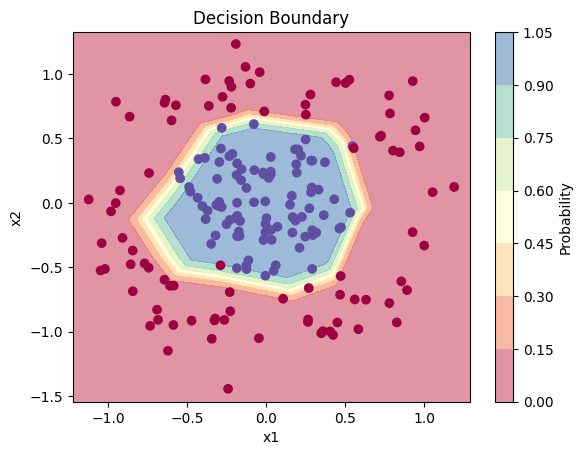

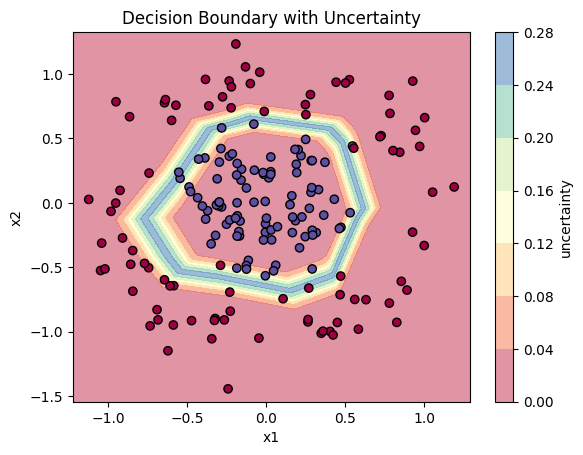

In [55]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

EPOCHS = 1000

model = Network(layers =
    [
        Linear(2, 10, name="input"),
        Activation(ReLU(), name="relu1"),
        Linear(10, 10, name="middle"),
        Activation(ReLU(), name="relu2"),
        Linear(10, 1, name="output"),
        Activation(Sigmoid(), name="sigmoid")
    ]
)

def load_data():
    X, Y = make_circles(noise=0.15, factor=0.3, random_state=1, n_samples=500)
    Y = Y.reshape(-1, 1)
    Y = Y.reshape((Y.shape[0], 1))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.36, random_state=42)
    return X_train, X_test, y_train, y_test


criterion = BinaryCrossEntropyLoss()
X_train, X_test, y_train, y_test = load_data()
for epoch in range(1, EPOCHS + 1):
    out = model(X_train)
    loss_gradient = criterion.gradient(y_train, out)
    model.backward(loss_gradient)
    model.update(lr=0.001)
    if epoch % 10 == 0:
        loss = criterion.loss(y_train, out)
        acc = (np.where(out > 0.5, 1, 0) == y_train).mean()
        print(f"Epoch: {epoch}, Loss:{loss}, Acc: {acc}")

Epoch: 10, Loss:0.6937110049221468, Acc: 0.35625
Epoch: 20, Loss:0.6867441567344018, Acc: 0.40625
Epoch: 30, Loss:0.6793644178703772, Acc: 0.5875
Epoch: 40, Loss:0.6692080930606629, Acc: 0.8
Epoch: 50, Loss:0.6528010264367438, Acc: 0.875
Epoch: 60, Loss:0.6267654895773723, Acc: 0.875
Epoch: 70, Loss:0.5866723276569837, Acc: 0.865625
Epoch: 80, Loss:0.5306414795282132, Acc: 0.86875
Epoch: 90, Loss:0.46546483233253577, Acc: 0.86875
Epoch: 100, Loss:0.402113664842821, Acc: 0.865625
Epoch: 110, Loss:0.34417920832024285, Acc: 0.86875
Epoch: 120, Loss:0.29566121870685336, Acc: 0.890625
Epoch: 130, Loss:0.278805521909678, Acc: 0.878125
Epoch: 140, Loss:0.2244910005543786, Acc: 0.946875
Epoch: 150, Loss:0.20075621153348747, Acc: 0.94375
Epoch: 160, Loss:0.13949632744680404, Acc: 0.971875
Epoch: 170, Loss:0.12026856959211182, Acc: 0.971875
Epoch: 180, Loss:0.10680703949245714, Acc: 0.978125
Epoch: 190, Loss:0.09266225146727232, Acc: 0.978125
Epoch: 200, Loss:0.08333846840344165, Acc: 0.978125
E

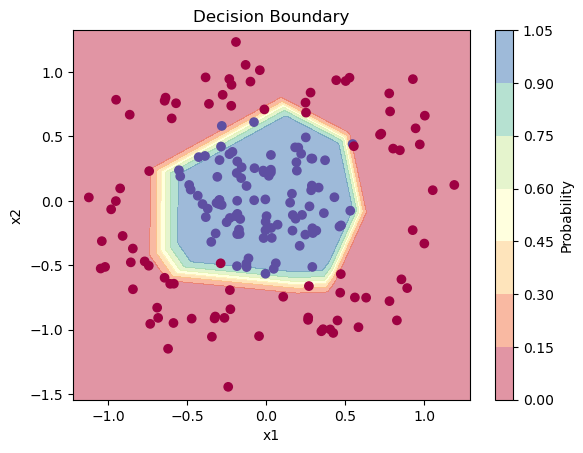

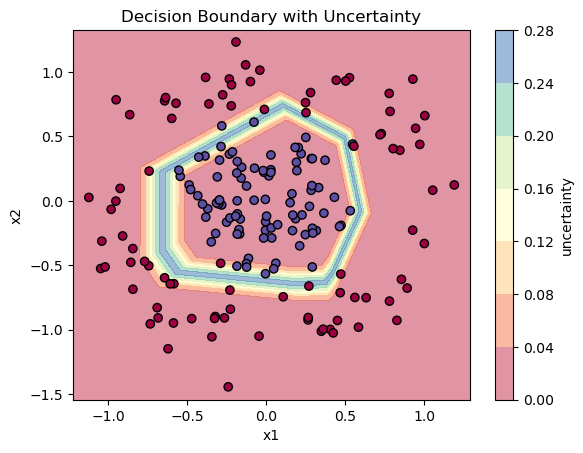

In [56]:
def plot_decision_boundary_and_uncertainty(model, X, Y):
    # Set min and max values and give it some padding
    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.01
    # Generate a grid of points with distance h between them
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    # Predict the function value for the whole gid
    Z = model.forward(np.c_[x1.ravel(), x2.ravel()])
    Z = Z.reshape(x1.shape)
    # Plot the contour and training examples
    plt.contourf(x1, x2, Z, alpha=0.5, cmap=plt.cm.Spectral)
    plt.colorbar(label='Probability')
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=Y.reshape(-1), cmap=plt.cm.Spectral)
    plt.title("Decision Boundary")
    plt.show()

    uncertainty = Z * (1 - Z)
    uncertainty = uncertainty.reshape(x1.shape)
    # Plot the contour and training examples
    plt.contourf(x1, x2, uncertainty, alpha=0.5, cmap=plt.cm.Spectral)
    plt.colorbar(label='uncertainty')
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=Y.reshape(-1), cmap=plt.cm.Spectral, edgecolors='k')

    plt.title("Decision Boundary with Uncertainty")
    plt.show()

plot_decision_boundary_and_uncertainty(model, X_test, y_test)

### Problem 5 (5 points)

Run the provided code to visualize the output of the last layer, gradients, and weights.
Observe and analyze the visualizations.

You should see the decision boundary for each feature in the last layer.
The gradients and weights also provide insights into the learning process of the network.

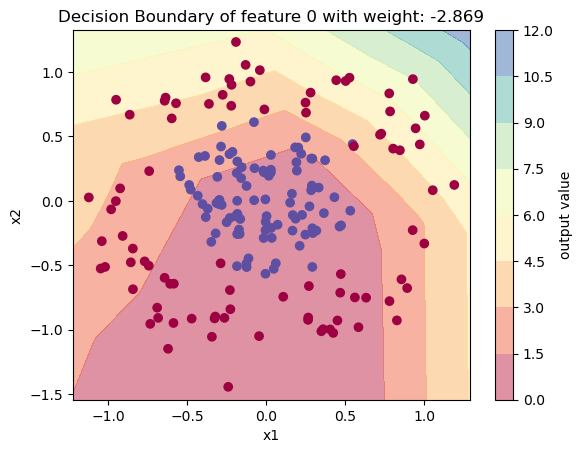

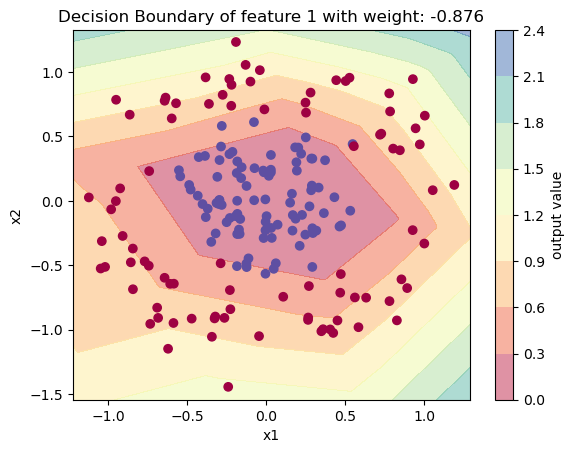

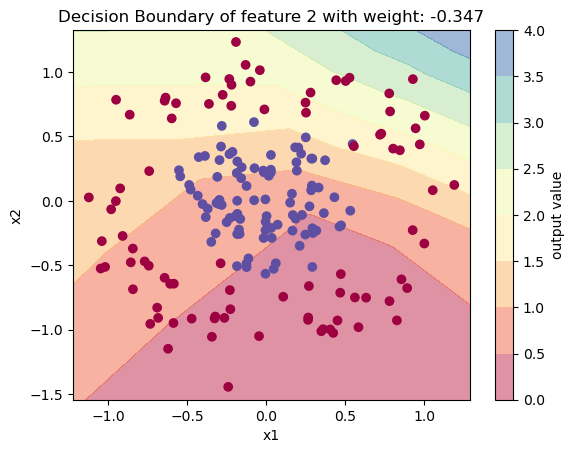

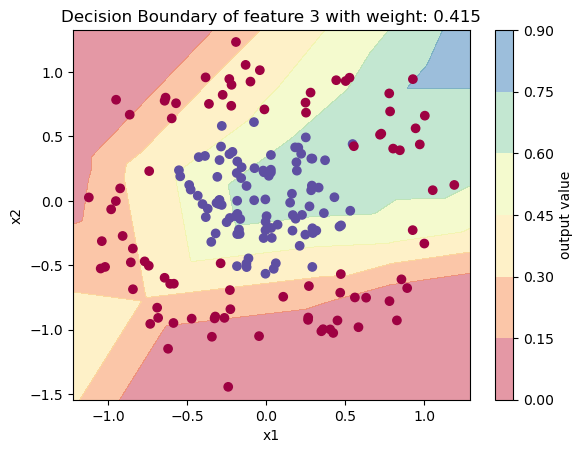

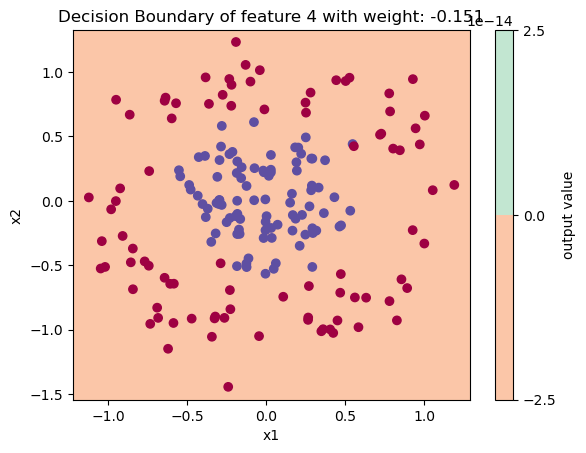

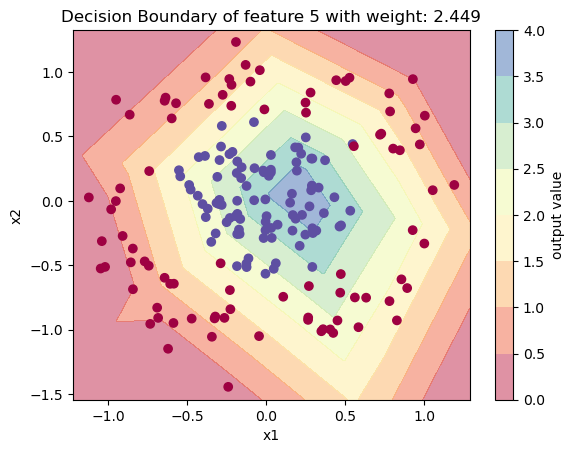

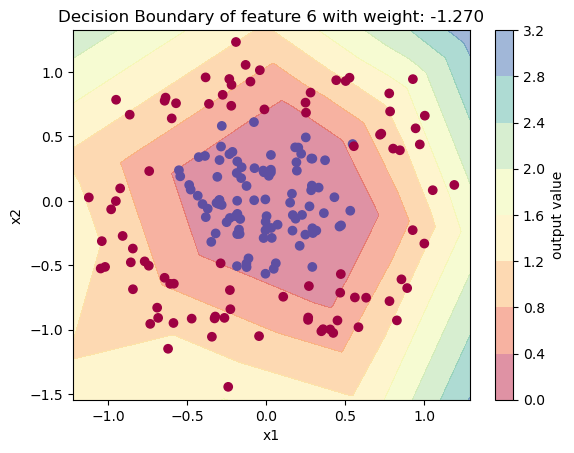

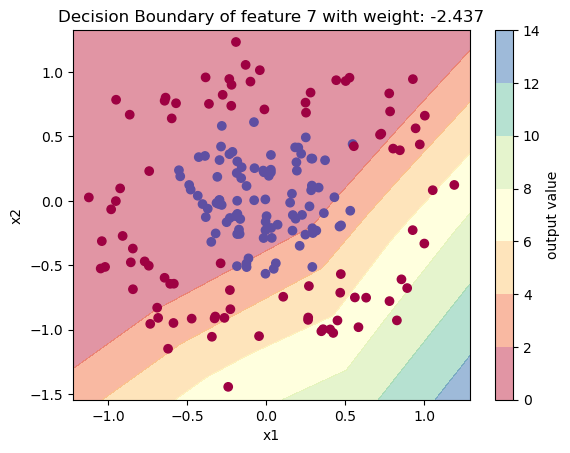

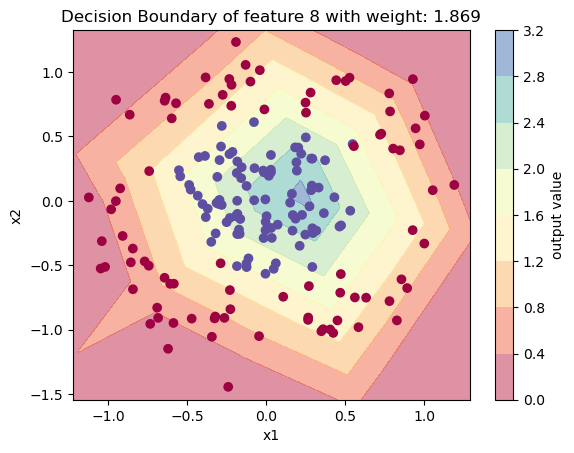

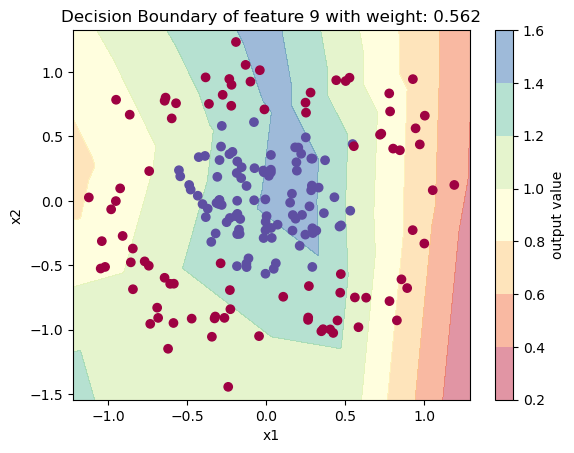

In [57]:
def plot_decision_boundary_per_feature_last_layer(model, X, Y):
    # Set min and max values and give it some padding
    x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.01
    # Generate a grid of points with distance h between them
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    # Predict the function value for the whole gid
    Z = model.forward(np.c_[x1.ravel(), x2.ravel()], last_layer=True)
    Z = Z.reshape([x1.shape[0], x1.shape[1], -1])
    last_layer_weight = model.layers[-2].W.reshape(-1)
    for feature_idx, feature_w in enumerate(last_layer_weight):
        feature = Z[:, :, feature_idx]
        plt.contourf(x1, x2, feature, alpha=0.5, cmap=plt.cm.Spectral)
        plt.colorbar(label='output value')
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.scatter(X[:, 0], X[:, 1], c=Y.reshape(-1), cmap=plt.cm.Spectral)
        plt.title("Decision Boundary of feature %d with weight: %.3f" % (feature_idx, feature_w))
        plt.show()

plot_decision_boundary_per_feature_last_layer(model, X_test, y_test)

In [58]:
import matplotlib.colors as mcolors
colors = ['yellow', "red", "black", "orange", 'yellow']  # Red to White to Blue
n_bins = 100  # Number of bins in the colormap
cmap_name = "custom1"
# Create the colormap
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


def visualize_layer(layer, visualize_gradient = True):
    if not hasattr(layer, "gradient_w"):
        return
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    # Assuming layer.grad_W and layer.grad_b exist

    if visualize_gradient:
        _W = layer.gradient_w
        _b = layer.gradient_b
        sns.heatmap(_W, ax=axs[0], center=0, cmap='coolwarm')
    else:
        _W = layer.W
        _b = layer.b
        sns.heatmap(_W, ax=axs[0], center=0, cmap=cm,  vmin=-1, vmax=1)
    print(_W.shape, _b.shape)
    # Visualize gradients of weights

    if visualize_gradient:
        axs[0].set_title('Gradient of Weights')
    else:
        axs[0].set_title('Weights')

    # Visualize gradients of biases
    # Note: grad_b is 2D (1 x output_dim), so we flatten it for easier visualization
    axs[1].plot(_b.flatten(), marker='o')
    if visualize_gradient:
        axs[1].set_title('Gradient of Biases')
    else:
        axs[1].set_title('Biases')
    axs[1].set_xlabel('Bias Index')
    axs[1].set_ylabel('Value')

    plt.show()

(2, 10) (10,)


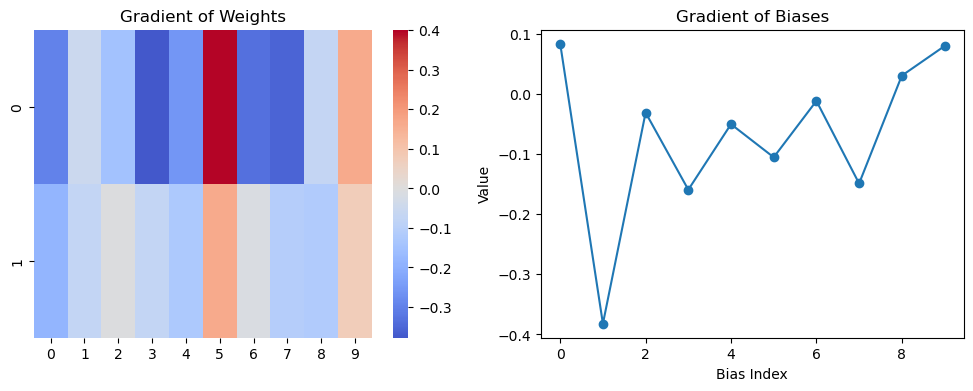

(10, 10) (10,)


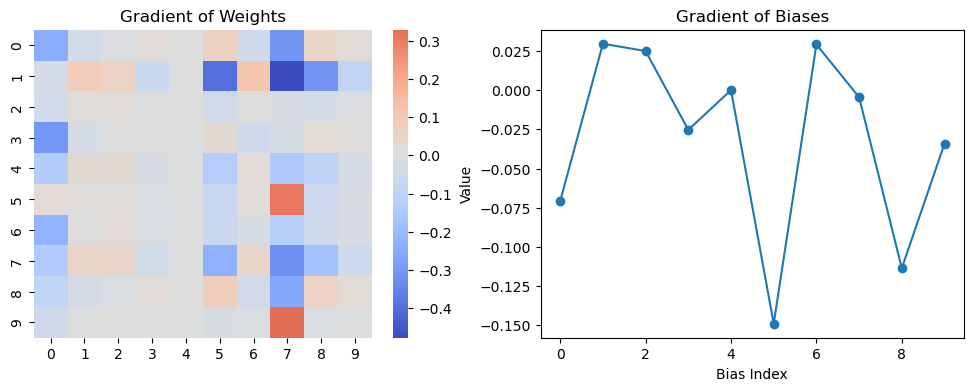

(10, 1) (1,)


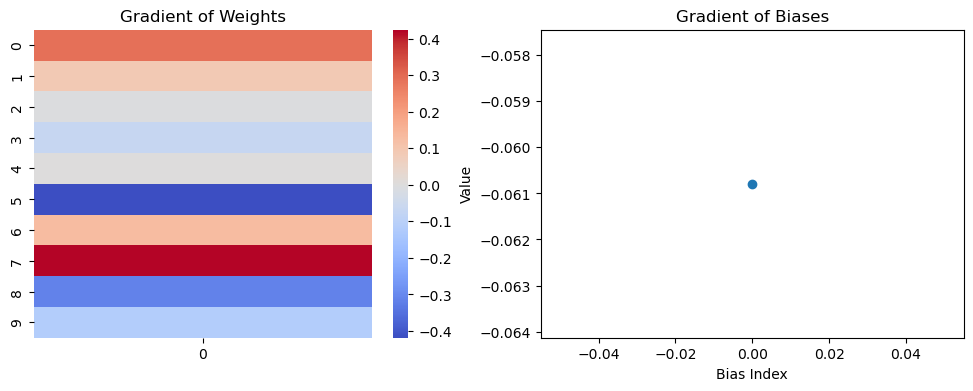

In [59]:
for layer in model.layers:
    visualize_layer(layer)

(2, 10) (1, 10)


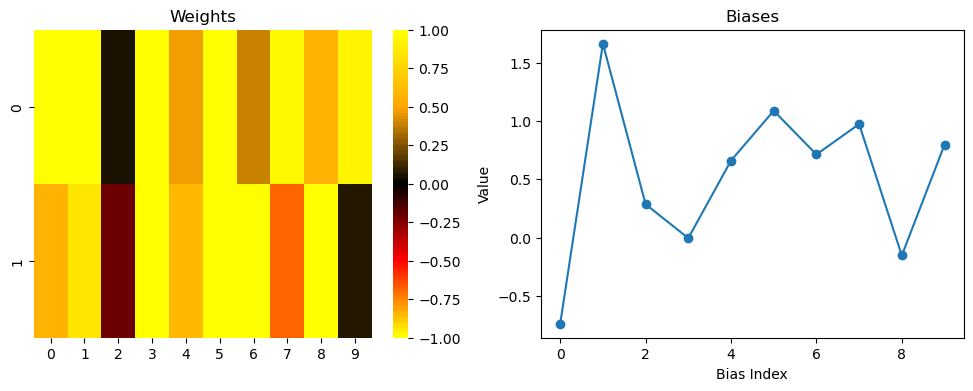

(10, 10) (1, 10)


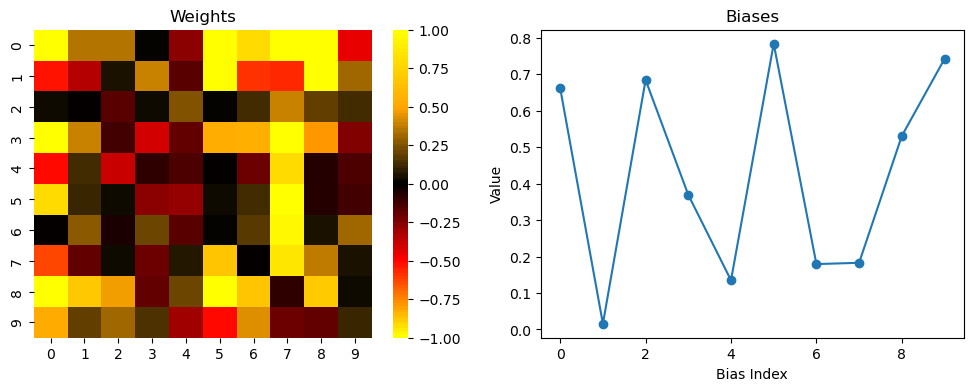

(10, 1) (1, 1)


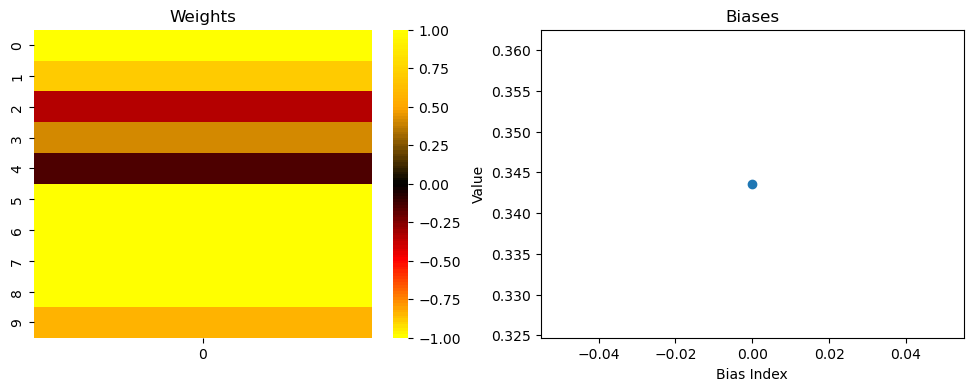

In [60]:
for layer in model.layers:
    visualize_layer(layer, visualize_gradient=False)

Answer:

The decision boundary plots clearly illustrate that different features contribute differently to the final predictions. This is expected, as the model is highly nonlinear, and the decision processes are fairly complex.

From the plots of decision boundaries of features and their corresponding weights, it is evident that features with very small weights, such as features 2--4, and 9, have poor decision boundaries that fail to effectively separate the two classes. On the other hand, features with larger weights demonstrate better class separation and exhibit strong positive influences on the output. The neural network has learned to assign higher weights to features that are more useful in distinguishing between classes.

The gradient and weight plots reveal that the important featuers other than 2--4, and 9 have higher absolute weights and gradient magnitudes in the last layer, which is responsible for making predictions. In contrast, the less important features have lower weights, signifying their reduced significance.

### Problem 6 (10 points)

Modify the network architecture to remove all intermediate ReLU activations.
Retrain this network without the ReLU activations and visualize the decision boundary and uncertainty of the retrained network.
Observe how the lack of ReLU activations affects the network's ability to learn non-linear patterns.

Epoch: 10, Loss:0.6927819280042755, Acc: 0.484375
Epoch: 20, Loss:0.6923505688106163, Acc: 0.375
Epoch: 30, Loss:0.6921857437322154, Acc: 0.409375
Epoch: 40, Loss:0.6921225960705667, Acc: 0.440625
Epoch: 50, Loss:0.6920981353819575, Acc: 0.440625
Epoch: 60, Loss:0.6920883769683697, Acc: 0.45
Epoch: 70, Loss:0.6920842520145469, Acc: 0.453125
Epoch: 80, Loss:0.6920823395943739, Acc: 0.453125
Epoch: 90, Loss:0.6920813407727587, Acc: 0.453125
Epoch: 100, Loss:0.6920807520171018, Acc: 0.453125
Epoch: 110, Loss:0.692080369574016, Acc: 0.453125
Epoch: 120, Loss:0.6920801046505604, Acc: 0.453125
Epoch: 130, Loss:0.6920799141749117, Acc: 0.453125
Epoch: 140, Loss:0.6920797744789127, Acc: 0.453125
Epoch: 150, Loss:0.6920796709834154, Acc: 0.45
Epoch: 160, Loss:0.6920795939221932, Acc: 0.45
Epoch: 170, Loss:0.6920795364036307, Acc: 0.45
Epoch: 180, Loss:0.6920794934219566, Acc: 0.446875
Epoch: 190, Loss:0.6920794612860662, Acc: 0.446875
Epoch: 200, Loss:0.6920794372536431, Acc: 0.446875
Epoch: 21

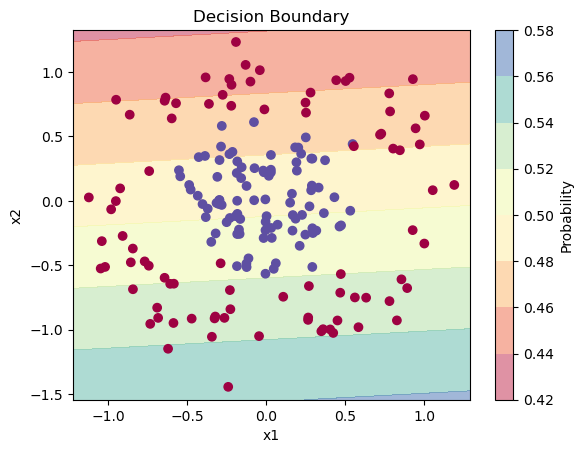

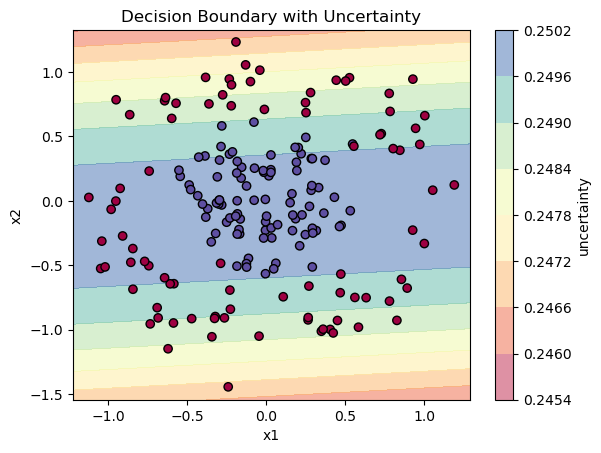

In [61]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

EPOCHS = 1000

model_lin = Network(layers =
    [
        Linear(2, 10, name="input"),
        # Activation(ReLU(), name="relu1"),
        Linear(10, 10, name="middle"),
        # Activation(ReLU(), name="relu2"),
        Linear(10, 1, name="output"),
        Activation(Sigmoid(), name="sigmoid")
    ]
)

print(model_lin)

def load_data():
    X, Y = make_circles(noise=0.15, factor=0.3, random_state=1, n_samples=500)
    Y = Y.reshape(-1, 1)
    Y = Y.reshape((Y.shape[0], 1))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.36, random_state=42)
    return X_train, X_test, y_train, y_test


criterion = BinaryCrossEntropyLoss()
X_train, X_test, y_train, y_test = load_data()
for epoch in range(1, EPOCHS + 1):
    out = model_lin(X_train)
    loss_gradient = criterion.gradient(y_train, out)
    model_lin.backward(loss_gradient)
    model_lin.update(lr=0.001)
    if epoch % 10 == 0:
        loss = criterion.loss(y_train, out)
        acc = (np.where(out > 0.5, 1, 0) == y_train).mean()
        print(f"Epoch: {epoch}, Loss:{loss}, Acc: {acc}")
plot_decision_boundary_and_uncertainty(model_lin, X_test, y_test)

Answer:

After removing all intermediate ReLU activations, we clearly observe that the model has lost its predictive power, essentially becoming a linear model. In the previous setup with ReLU activations, the uncertainty was high only at the decision boundary and low everywhere else. However, in this case, since the model is now just a linear decision boundary passing somewhat mid-way through the points, with adjustments based on the number of samples and the optimization procedure, the uncertainty is higher throughout the feature space.

### Problem 7 (10 points)

Answer the following questions:
  - If handling multi-class classification, which final-layer activation should we use? What is the probability for each class?
  - Derive the maximum likelihood estimation for that layer. What is the derived loss function? (over a dataset $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^N$, where each $y_i$ is a class number between $[1,K]$, suppose there are totally $K$ class)

Answer:

1. For multi-class classification, we should use the Softmax activation in the final layer. The probability for each class is given by:
    $$
    P(y=j \mid \mathbf{x}) = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}},
    $$
    where $z_j$ is the $j$-th element of the output logits $\mathbf{z}$ and $K$ is the total number of classes.

2. The MLE for softmax is
    $$
    \log L(\mathcal{D}) = \sum_{i=1}^{N} \log P(y=y_i \mid x_i).
    $$
    Here, $L(\mathcal{D})$ represents the likelihood of the observed dataset $\mathcal{D}$, which consists of $N$ samples. The likelihood is the product of the probabilities of each sample, assuming they are independent and identically distributed (i.i.d.). By taking the logarithm of the likelihood, we convert the product into a sum, which is more convenient for optimization.
    
    Now, let's expand the predicted probability $P(y=k | x_i)$ using the softmax function:
    $$
    P(y=k | x_i) = \frac{e^{f_k(x_i)}}{\sum_{j=1}^{K} e^{f_j(x_i)}}
    $$
    Here, $f_k(x_i)$ represents the output of the model (often called logits) for the $k$-th class given the input $x_i$.
    Substituting the softmax function into the NLL loss:
    $$
    J(\mathcal{D}) = -\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} \mathbb{1}\{y_i=k\} \log \left(\frac{e^{f_k(x_i)}}{\sum_{j=1}^{K} e^{f_j(x_i)}}\right)
    $$
    Using the properties of logarithms, we can simplify the expression:
    $$
    J(\mathcal{D}) = -\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} \mathbb{1}\{y_i=k\} \left(f_k(x_i) - \log \sum_{j=1}^{K} e^{f_j(x_i)}\right)
    $$
    Now, let's introduce the one-hot encoding of the true class labels. Define $y_{ik} = \mathbb{1}\{y_i=k\}$, which means $y_{ik}$ is 1 if the true class of the $i$-th sample is $k$, and 0 otherwise.
    Replacing the indicator function with the one-hot encoding:
    $$
    J(\mathcal{D}) = -\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} y_{ik} \left(f_k(x_i) - \log \sum_{j=1}^{K} e^{f_j(x_i)}\right)
    $$
    This expression is the Cross-Entropy loss function. It measures the dissimilarity between the predicted probability distribution (softmax output) and the true probability distribution (one-hot encoded labels).
    The Cross-Entropy loss can be interpreted as the average number of bits needed to encode the true class labels using the predicted probability distribution. By minimizing the Cross-Entropy loss, the model learns to assign high probabilities to the correct classes and low probabilities to the incorrect classes.
    In summary, we derived the Cross-Entropy loss from the Negative Log-Likelihood loss by expanding the predicted probabilities using the softmax function and introducing the one-hot encoding of the true class labels. The resulting Cross-Entropy loss function is commonly used in multi-class classification problems and is optimized to maximize the likelihood of the observed data.

## Part 2: Evaluation and Regularization

### Problem 8 (15 points)
Implement the precision-recall curve and the ROC-AUC curve for binary classification.
Compare the plots obtained using the model with and without ReLU activations.
You can use your implementation from Problem 6.

- Compute the predicted probabilities for the positive class on the test set.
- The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives.
- The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives.
- Compute the True Positive Rate (TPR) and False Positive Rate (FPR) for various threshold values.
- Plot the ROC curve (FPR vs TPR) and compute the Area Under the Curve (AUC).

You can compare your implementation with `sklearn.metrics.precision_recall_curve`, `sklearn.metrics.roc_curve`, and `sklearn.metrics.auc` to verify the computation of the ROC curve and AUC values.

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def my_precision_recall_curve(y_true, y_score):
    # Sort scores and corresponding true labels in descending order based on the scores.
    # This is necessary to assess the model's predictions starting from the highest confidence.
    sorted_indices = np.argsort(-y_score)
    y_true = y_true[sorted_indices]
    y_score = y_score[sorted_indices]

    # Identify unique thresholds and the first occurrence of each in the sorted score list.
    # np.unique returns sorted unique values and the indices where these unique values first appear.
    thresholds, unique_indices = np.unique(y_score, return_index=True)

    # Initialize lists to store precision and recall values.
    precision = []
    recall = []

    # Append edge case at the end (precision=1, recall=0).
    # This corresponds to a scenario where no threshold is low enough to qualify any sample as positive.
    precision.append(1)
    recall.append(0)
    thresholds = np.append(thresholds, [0])  # to include this case in thresholds for plotting

    # Initial counts of true positives (tp) and false positives (fp).
    tp = 0
    fp = 0
    # False negatives (fn) initially considers all positives as not detected.
    fn = np.sum(y_true)  # all true positives
    n_positives = fn  # total number of actual positives

    # Iterate through thresholds in reverse order (from high score to low score).
    for idx in reversed(unique_indices):
        # Update tp and fp counts up to the current threshold index.
        while tp + fp < idx:
            # If the sample is a true positive, increase tp count.
            if y_true[tp + fp] == 1:
                tp += 1
            # Otherwise, it's a false positive, increase fp count.
            else:
                fp += 1
        # Compute precision: ratio of correctly predicted positive observations to total predicted positives.
        if tp + fp > 0:
            precision.append(tp / (tp + fp))
        else:
            precision.append(1)  # to handle divide by zero if tp and fp are both zero
        # Compute recall: ratio of correctly predicted positive observations to all actual positives.
        recall.append(tp / n_positives)

    # Reverse the lists to start from the lowest threshold (most inclusive).
    precision.reverse()
    recall.reverse()
    # Adjust thresholds array for proper alignment and exclude the last artificial zero added earlier.
    thresholds = np.roll(thresholds[::-1], -1)  # roll to shift elements to right, removing the extra zero

    return np.array(precision), np.array(recall), thresholds[:-1]  # Return arrays for precision, recall, and adjusted thresholds

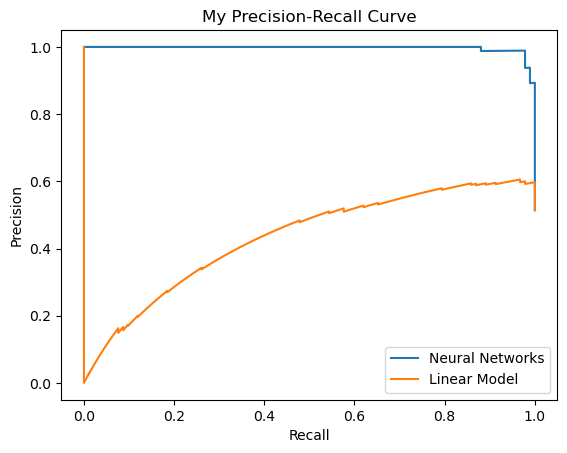

In [62]:
from sklearn.metrics import precision_recall_curve

y_score = model(X_test)
precision, recall, _ = my_precision_recall_curve(y_test, y_score.reshape(-1))

y_score_lin = model_lin(X_test)
precision_lin, recall_lin, _ = my_precision_recall_curve(y_test, y_score_lin.reshape(-1))


plt.figure()
plt.plot(recall, precision, label='Neural Networks')
plt.plot(recall_lin, precision_lin, label='Linear Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('My Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

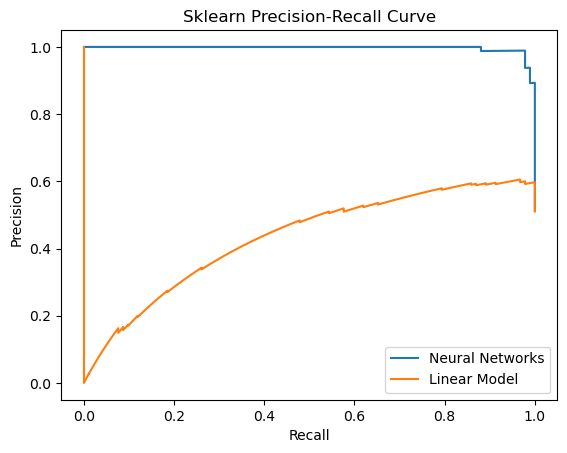

In [63]:
from sklearn.metrics import precision_recall_curve

y_score = model(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)

y_score_lin = model_lin(X_test)
precision_lin, recall_lin, _ = precision_recall_curve(y_test, y_score_lin)


plt.figure()
plt.plot(recall, precision, label='Neural Networks')
plt.plot(recall_lin, precision_lin, label='Linear Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Sklearn Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [73]:
from sklearn.metrics import roc_curve, auc

# TODO: Implement the ROC-AUC curve for binary classification
def my_roc_curve(y_test, y_score):
    thresholds = np.unique(y_score)
    tpr = []
    fpr = []
    
    for thresh in thresholds:
        y_pred = np.where(y_score >= thresh, 1, 0)
        tp = np.sum((y_pred == 1) & (y_test == 1))
        fp = np.sum((y_pred == 1) & (y_test == 0)) 
        fn = np.sum((y_pred == 0) & (y_test == 1))
        tn = np.sum((y_pred == 0) & (y_test == 0))
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
        
    return np.array(fpr), np.array(tpr), thresholds[::-1]

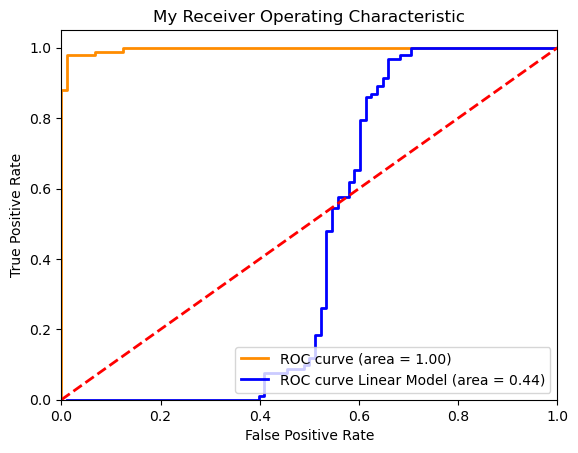

In [74]:
# You can compare your implementation with sklearn.metrics.roc_curve
# and sklearn.metrics.auc to verify the computation of the ROC curve and AUC
fpr, tpr, _ = my_roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
fpr_lin, tpr_lin, _ = my_roc_curve(y_test, y_score_lin)
roc_auc_lin = auc(fpr_lin, tpr_lin)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_lin, tpr_lin, color='blue', lw=2, label='ROC curve Linear Model (area = %0.2f)' % roc_auc_lin)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('My Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [71]:
from sklearn.metrics import roc_curve, auc

y_score = model(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

y_score_lin = model_lin(X_test)
fpr_lin, tpr_lin, _ = roc_curve(y_test, y_score_lin)
roc_auc_lin = auc(fpr_lin, tpr_lin)

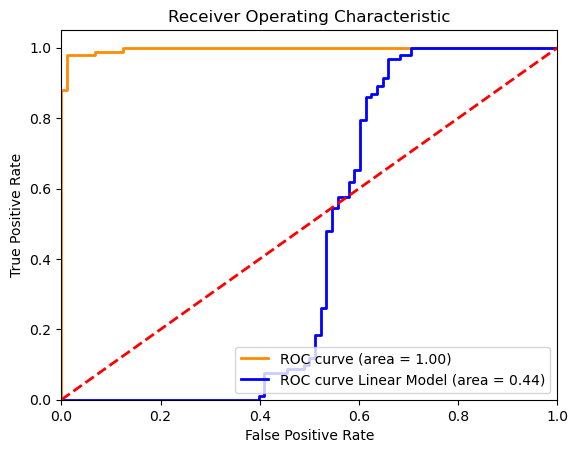

In [72]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_lin, tpr_lin, color='blue', lw=2, label='ROC curve Linear Model (area = %0.2f)' % roc_auc_lin)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Observations:

The non-linear network has better precision across different recall levels as compared to the linear model.

With ReLU activations, the model has better AUC scores.

### Problem 9 (10 points)

Implement weight decay (L2 regularization) in the `Linear_L2` layer.

Train the network with different weight decay values and visualize the learned weights for each model using `plot_decision_boundary_per_feature_last_layer`.
Observe how weight decay affects the magnitude and distribution of the learned weights.

In [16]:
class Linear_L2(Linear):
    """
    Linear Layer with L2 regularization.
    """
    def update(self, lr=0.01, weight_decay=0.01):
        if self.gradient_w is not None:
            self.W -= lr * (self.gradient_w + weight_decay * self.W)
        if self.gradient_b is not None:
            self.b -= lr * self.gradient_b

Epoch: 100, Loss:0.47342011380625115, Acc: 0.884375
Epoch: 200, Loss:0.07729366885635917, Acc: 0.98125
Epoch: 300, Loss:0.047535259404333036, Acc: 0.984375
Epoch: 400, Loss:0.0400157369339378, Acc: 0.98125
Epoch: 500, Loss:0.036594013501928035, Acc: 0.984375
Epoch: 600, Loss:0.03468934716980689, Acc: 0.984375
Epoch: 700, Loss:0.033457746175056494, Acc: 0.984375
Epoch: 800, Loss:0.0326070960741044, Acc: 0.984375
Epoch: 900, Loss:0.03195520211431938, Acc: 0.9875
Epoch: 1000, Loss:0.031406568609892105, Acc: 0.9875


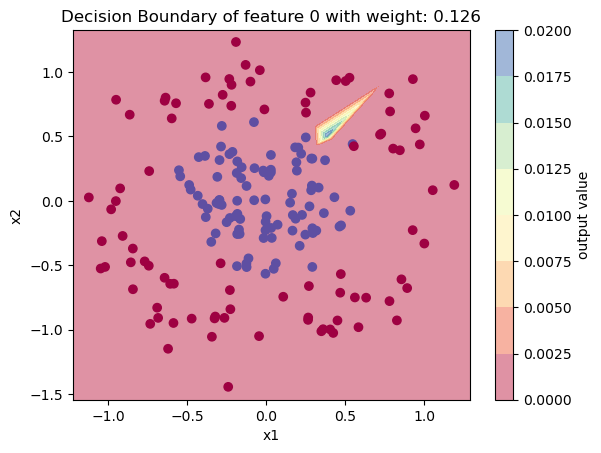

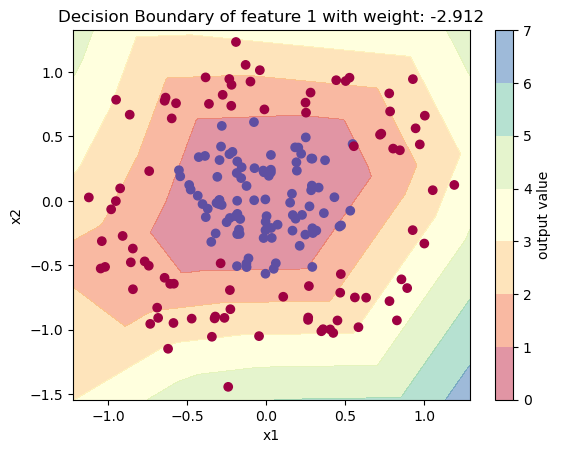

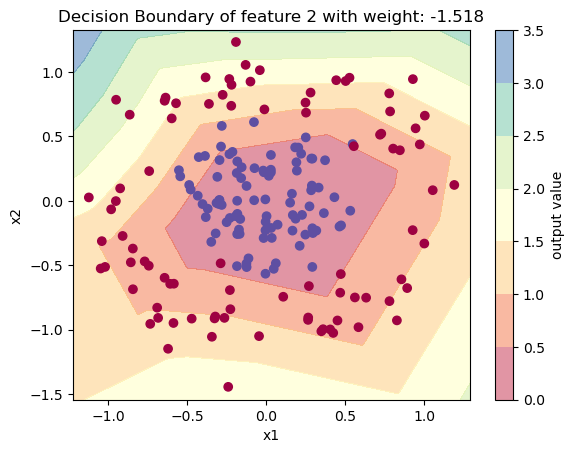

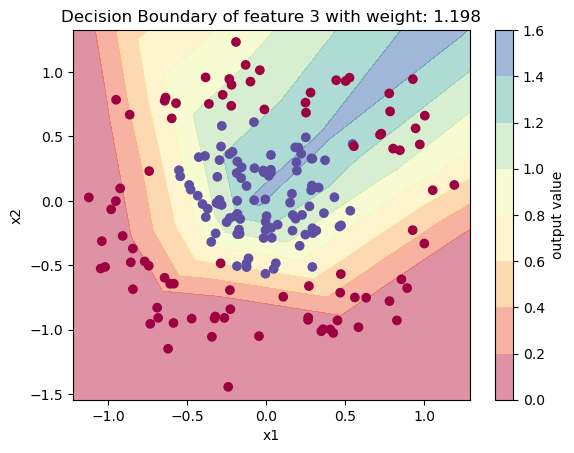

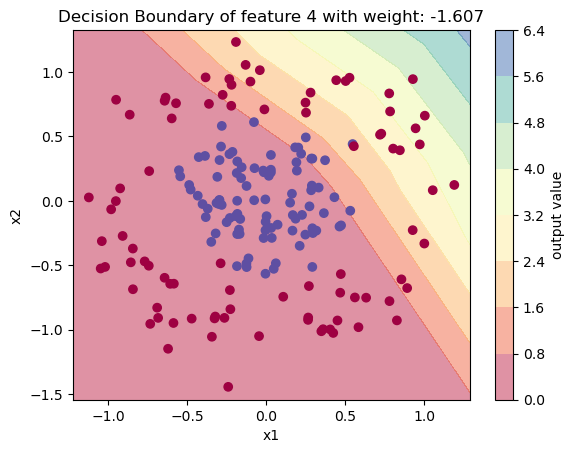

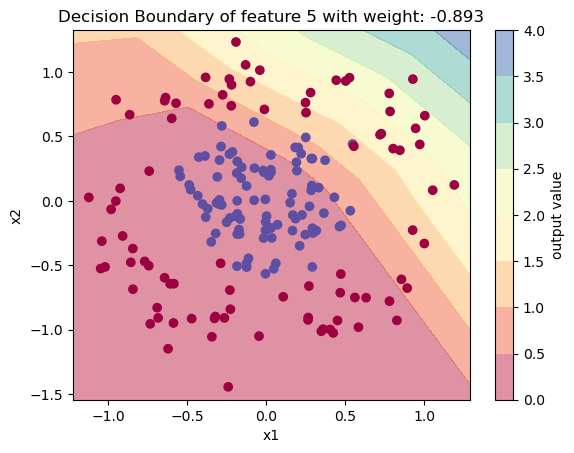

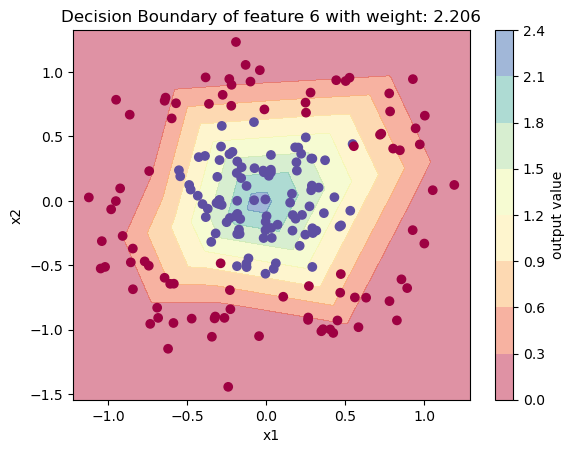

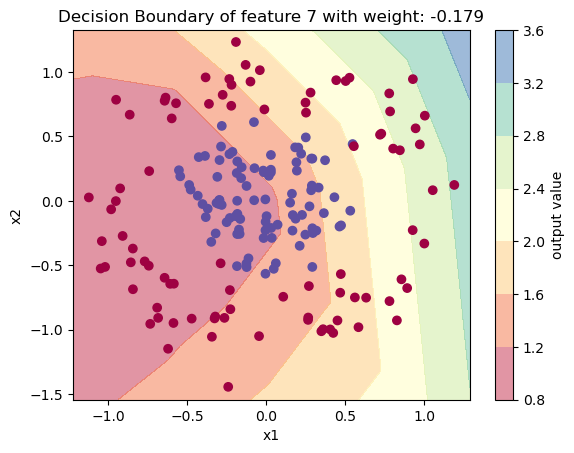

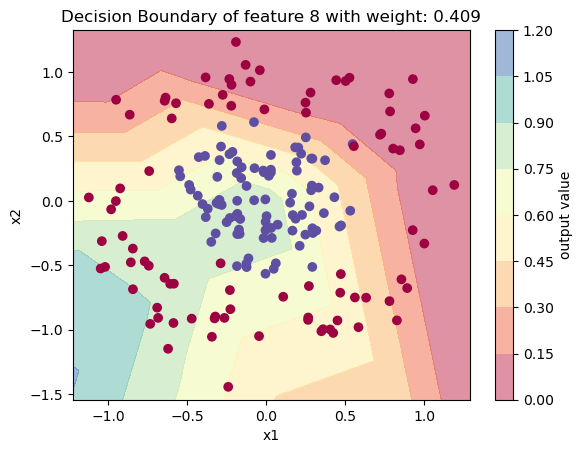

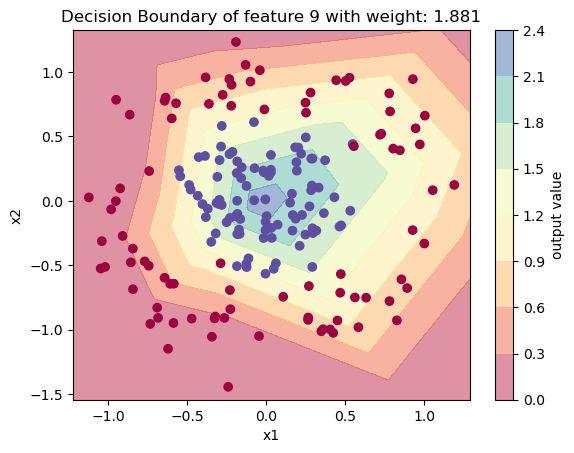

(2, 10) (1, 10)


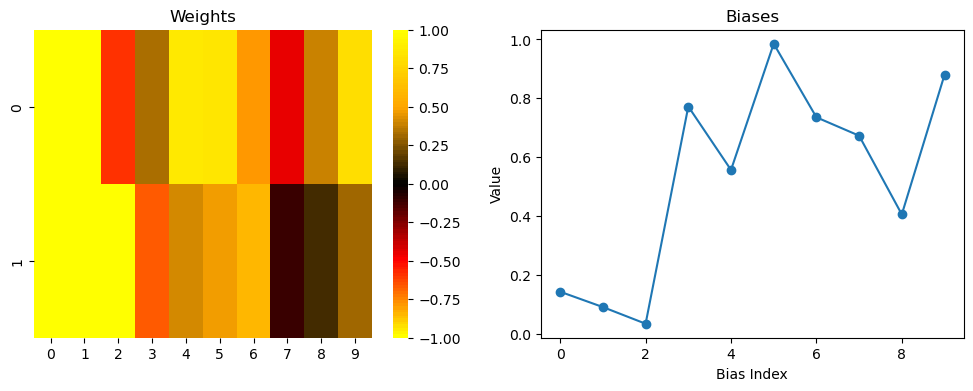

(10, 10) (1, 10)


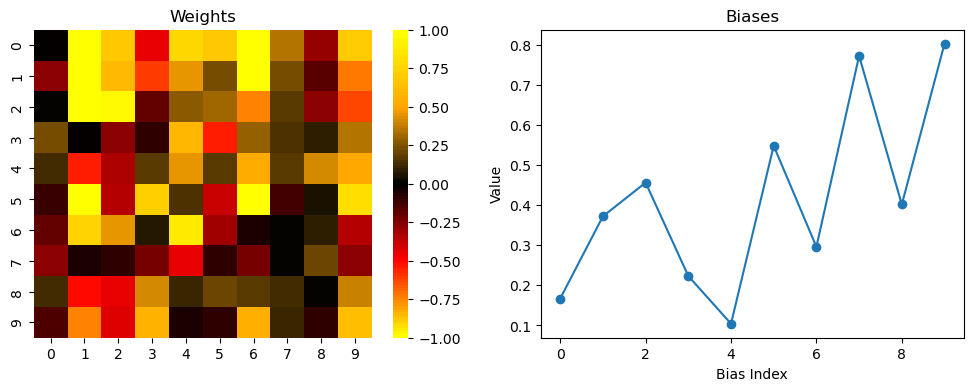

(10, 1) (1, 1)


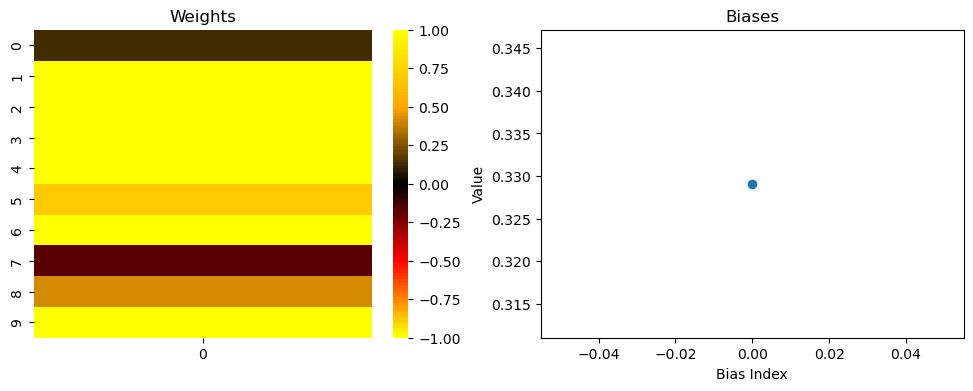

Epoch: 100, Loss:0.3950254685003454, Acc: 0.85625
Epoch: 200, Loss:0.07443615427798025, Acc: 0.9875
Epoch: 300, Loss:0.04830019492962293, Acc: 0.9875
Epoch: 400, Loss:0.04104376242847092, Acc: 0.9875
Epoch: 500, Loss:0.03799144953492402, Acc: 0.9875
Epoch: 600, Loss:0.03634236107561255, Acc: 0.9875
Epoch: 700, Loss:0.03533638275327636, Acc: 0.984375
Epoch: 800, Loss:0.034694474034717204, Acc: 0.984375
Epoch: 900, Loss:0.034274777641779886, Acc: 0.9875
Epoch: 1000, Loss:0.03398550308983046, Acc: 0.9875


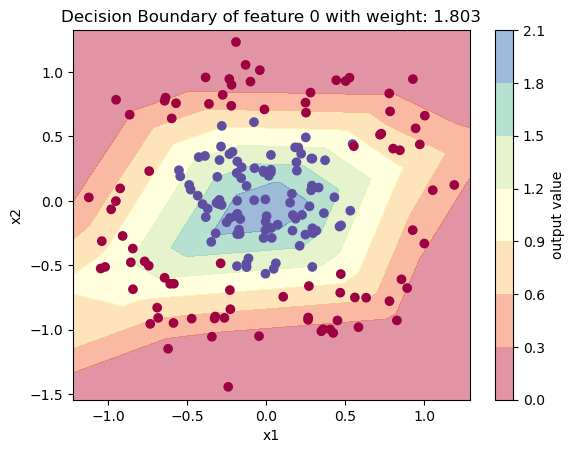

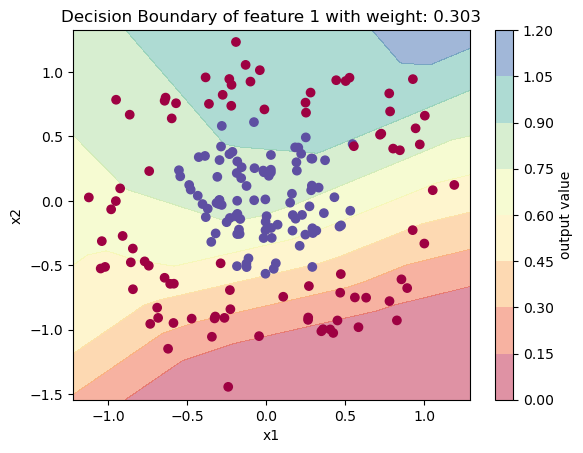

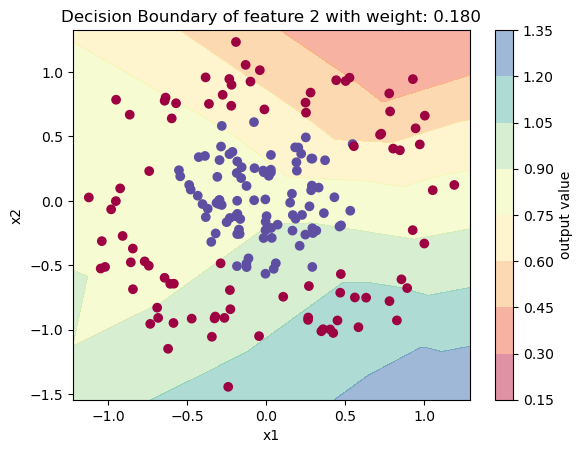

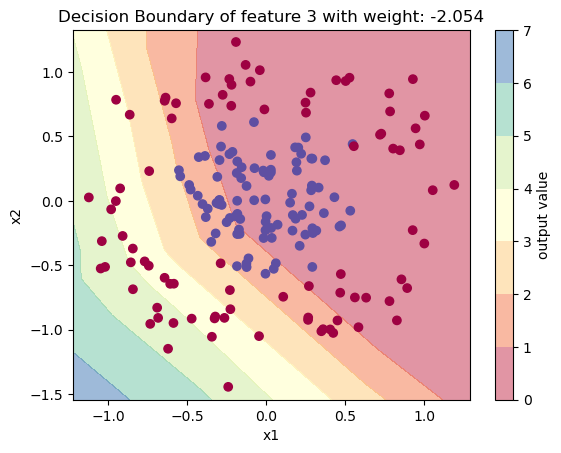

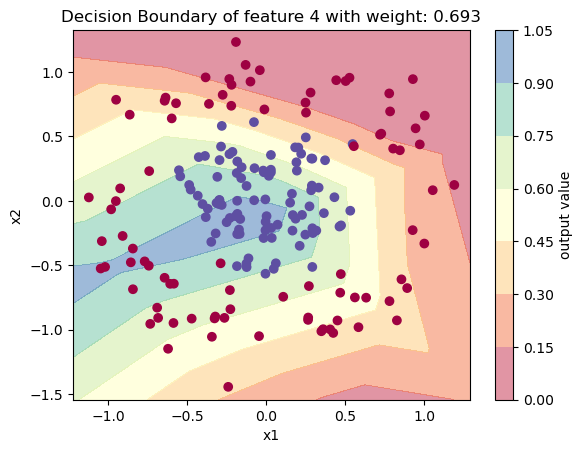

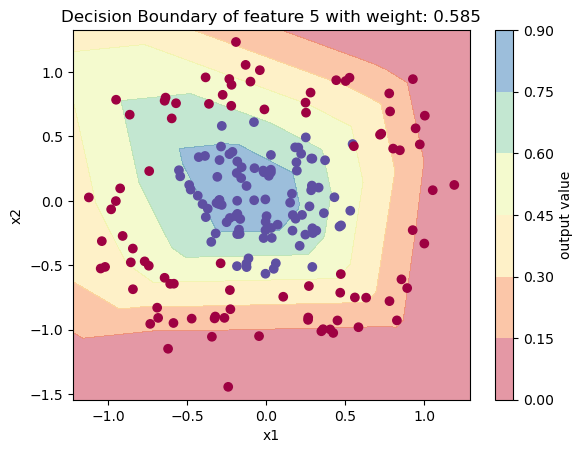

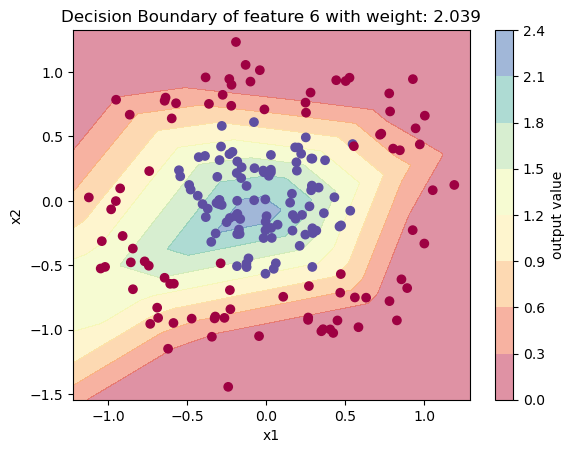

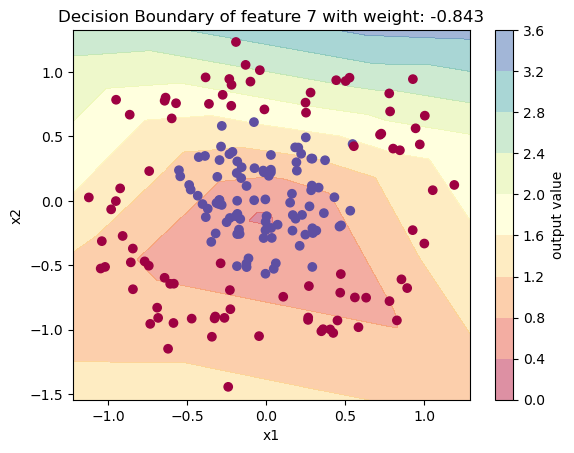

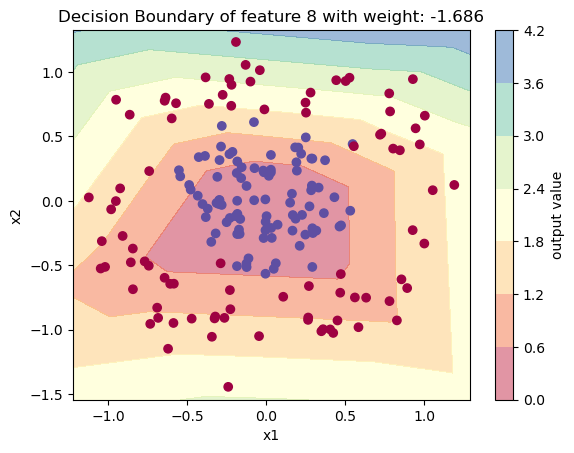

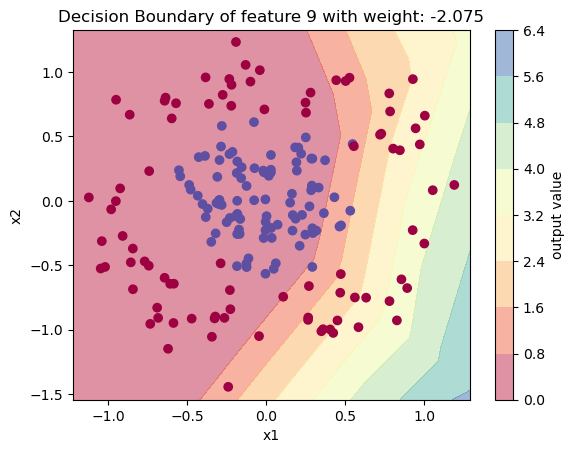

(2, 10) (1, 10)


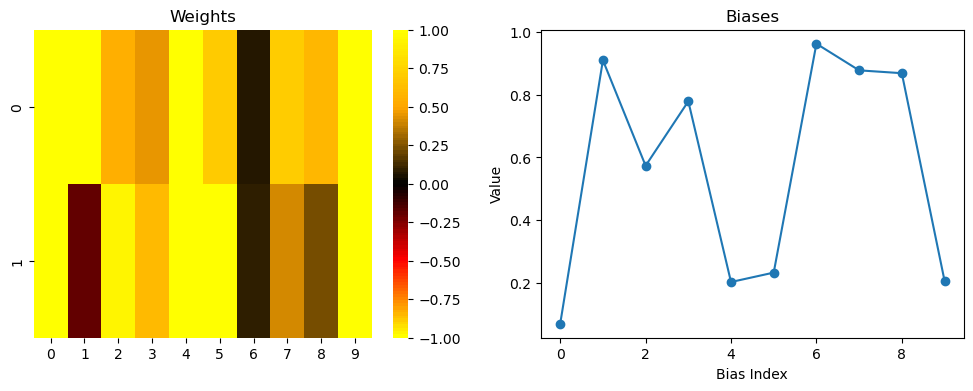

(10, 10) (1, 10)


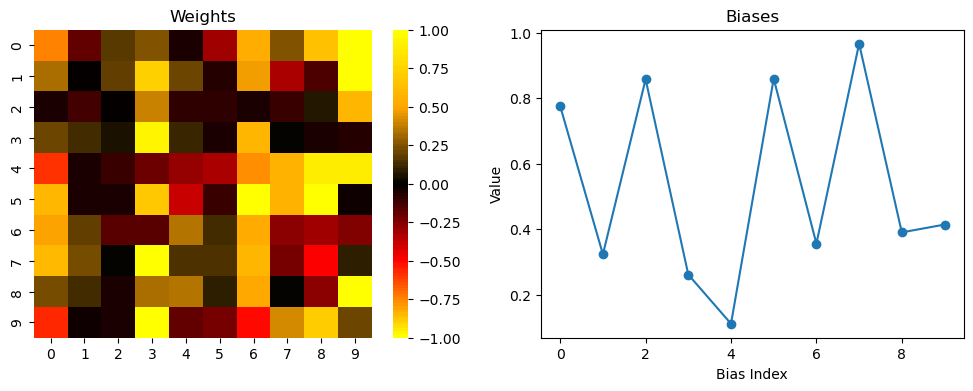

(10, 1) (1, 1)


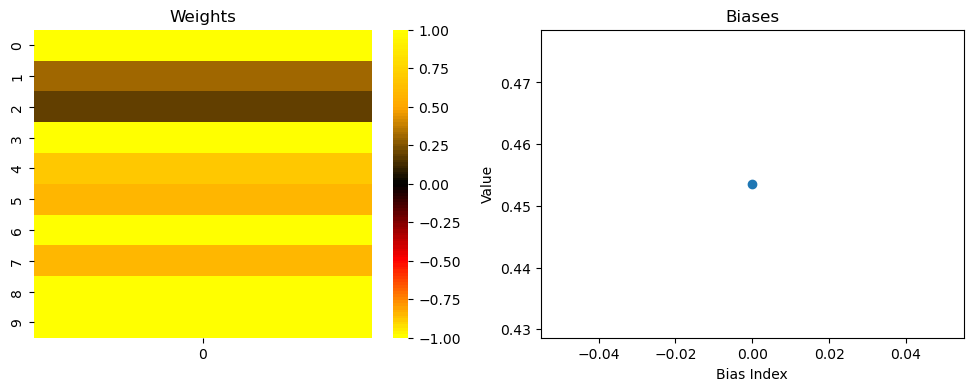

Epoch: 100, Loss:0.4441337084199434, Acc: 0.871875
Epoch: 200, Loss:0.10666290080802483, Acc: 0.984375
Epoch: 300, Loss:0.06403320145496669, Acc: 0.9875
Epoch: 400, Loss:0.05439237024396768, Acc: 0.990625
Epoch: 500, Loss:0.04991848488235605, Acc: 0.990625
Epoch: 600, Loss:0.047742557938660765, Acc: 0.99375
Epoch: 700, Loss:0.04652897854923023, Acc: 0.99375
Epoch: 800, Loss:0.0458189334304743, Acc: 0.99375
Epoch: 900, Loss:0.04528668903909024, Acc: 0.99375
Epoch: 1000, Loss:0.04441978135527106, Acc: 0.99375


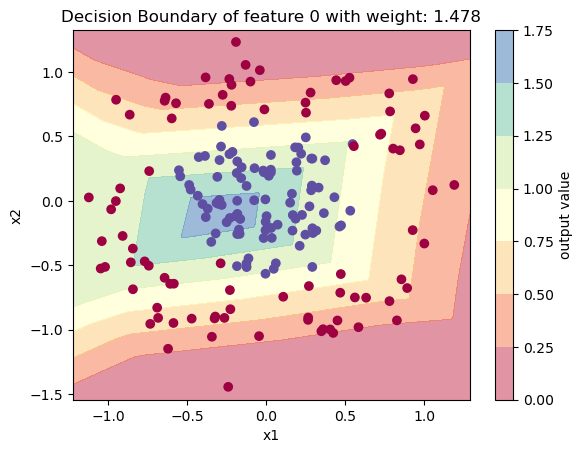

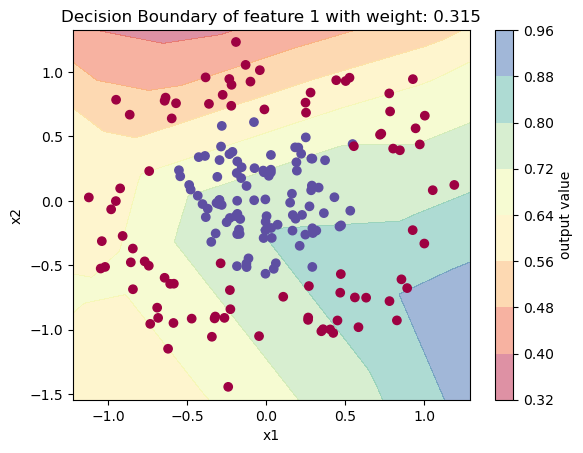

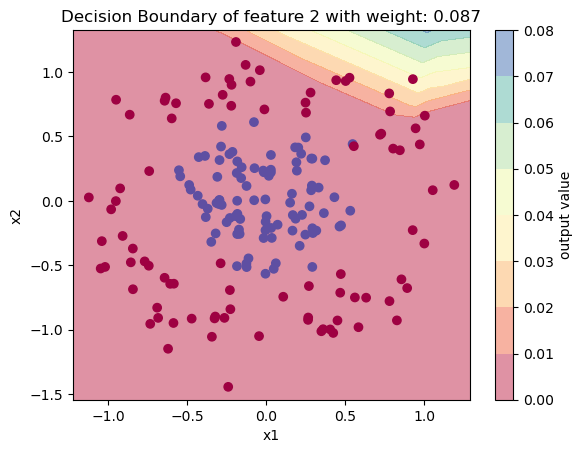

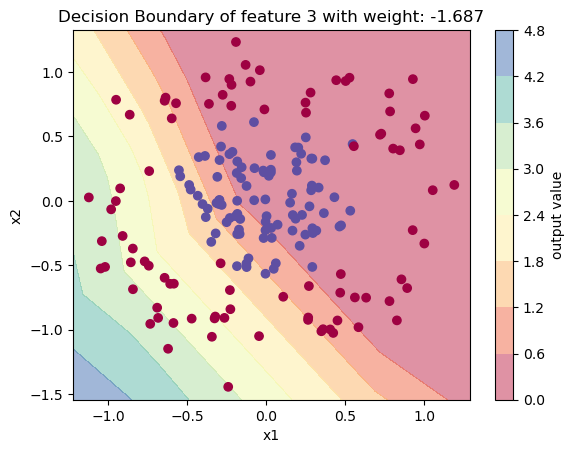

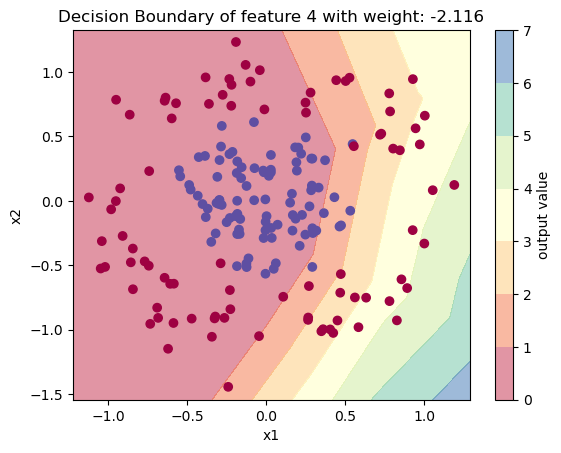

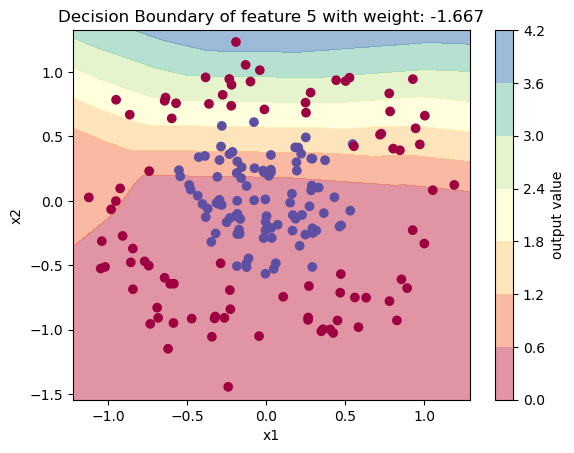

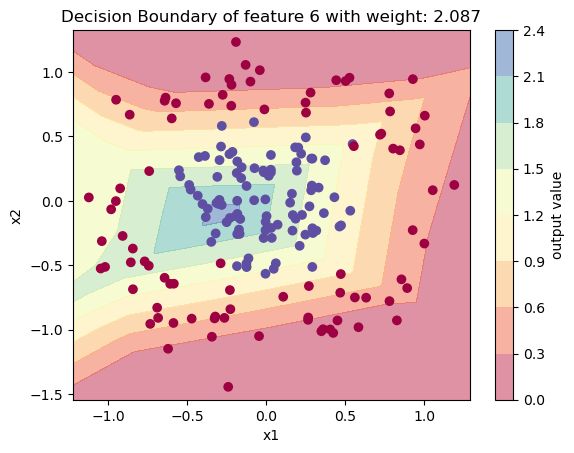

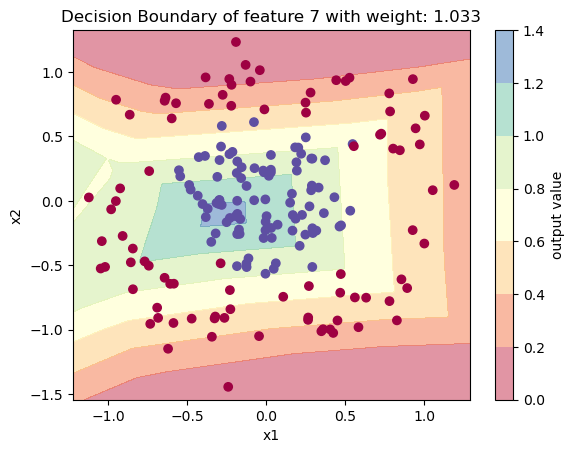

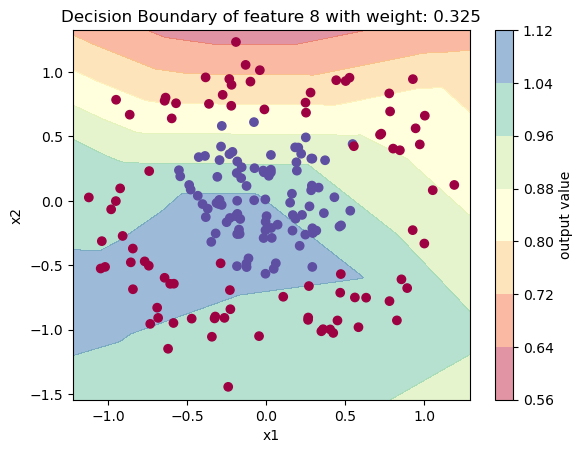

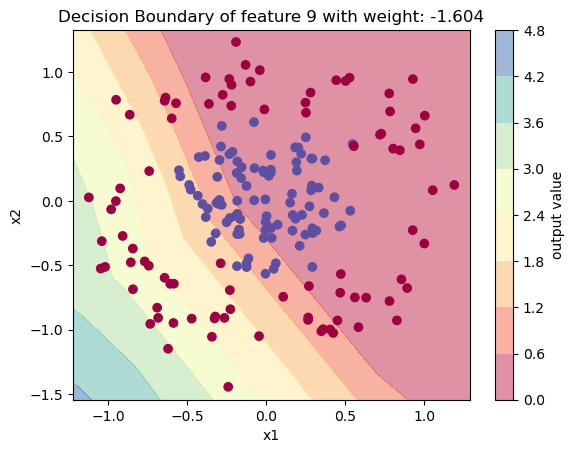

(2, 10) (1, 10)


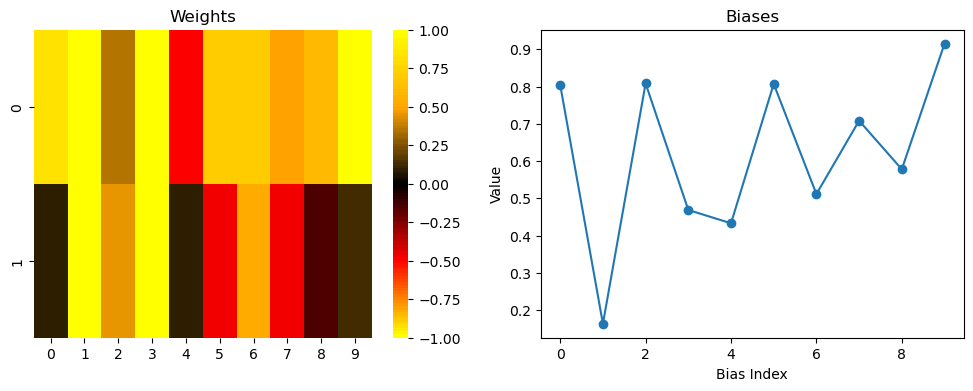

(10, 10) (1, 10)


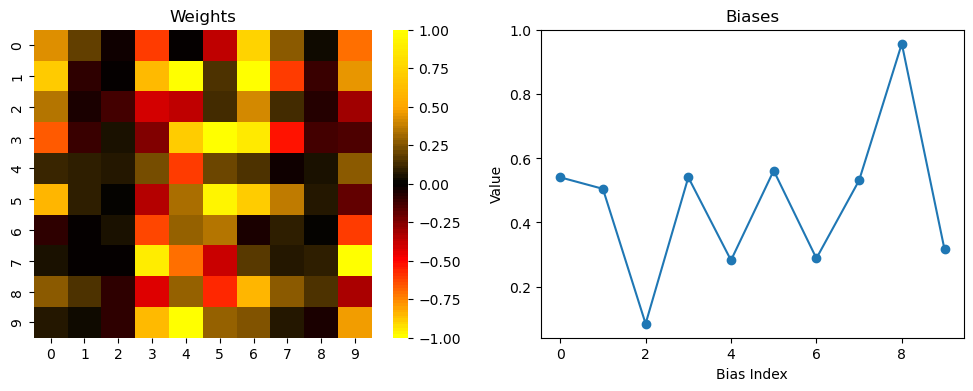

(10, 1) (1, 1)


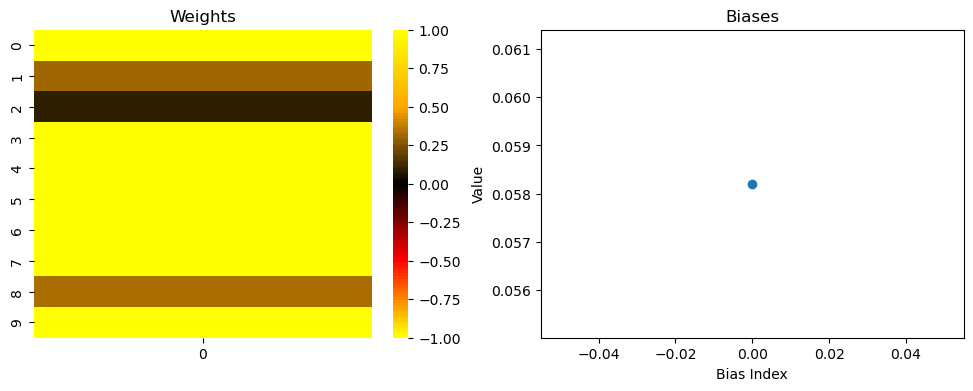

Epoch: 100, Loss:0.6806513944644749, Acc: 0.690625
Epoch: 200, Loss:0.6774402586748481, Acc: 0.678125
Epoch: 300, Loss:0.6608978338221594, Acc: 0.721875
Epoch: 400, Loss:0.5487739462575114, Acc: 0.8625
Epoch: 500, Loss:0.43271822793681364, Acc: 0.884375
Epoch: 600, Loss:0.34572439567842855, Acc: 0.9
Epoch: 700, Loss:0.21300834367809038, Acc: 0.984375
Epoch: 800, Loss:0.19124672097105022, Acc: 0.98125
Epoch: 900, Loss:0.18834887390088279, Acc: 0.984375
Epoch: 1000, Loss:0.18714308308589014, Acc: 0.984375


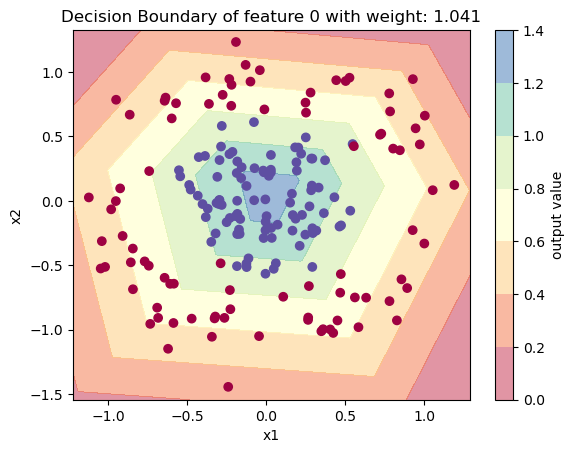

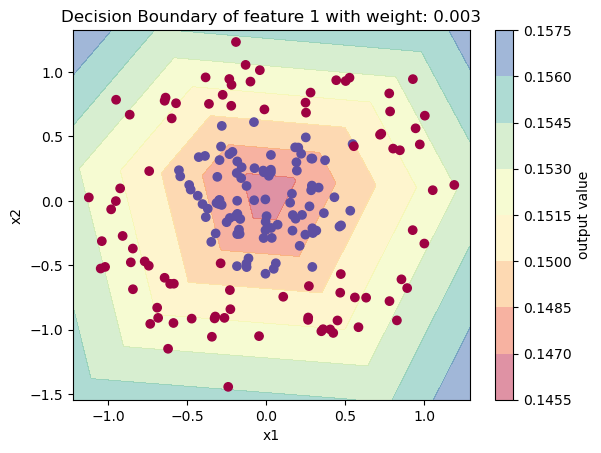

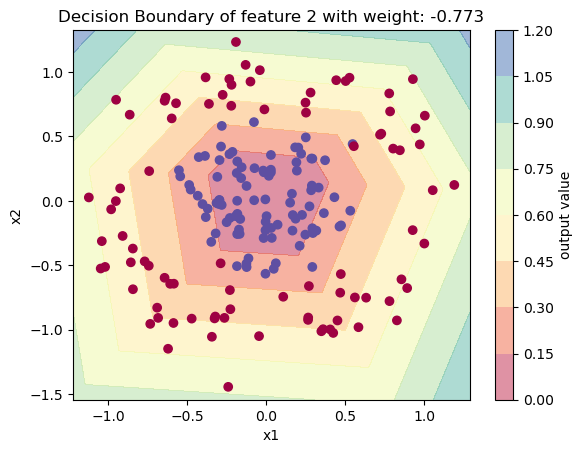

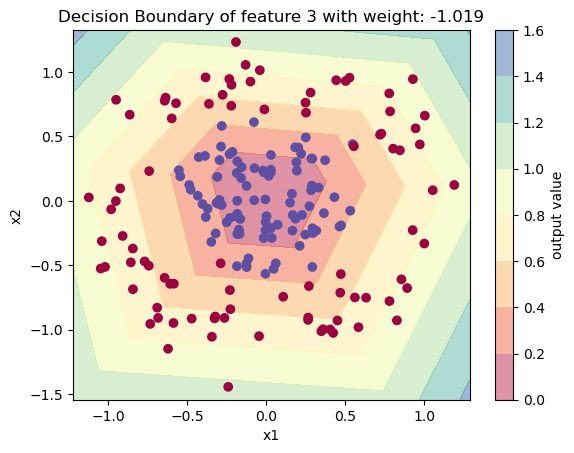

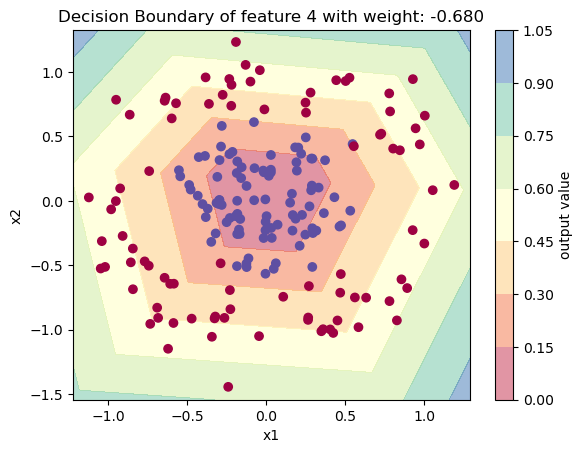

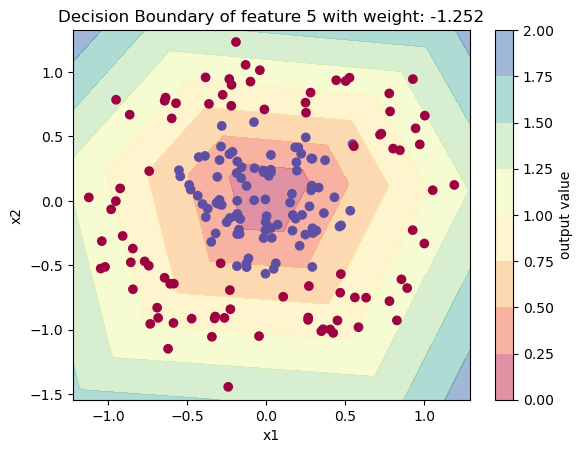

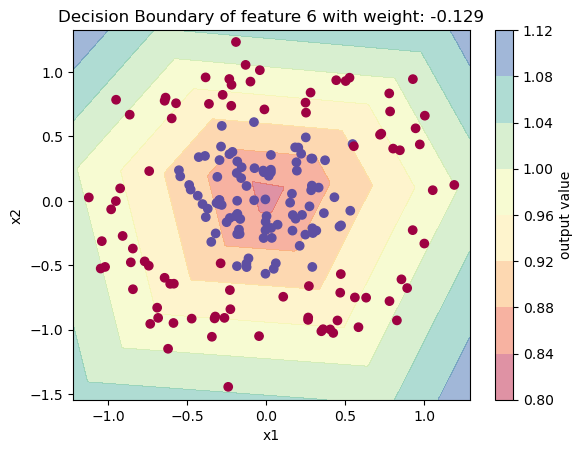

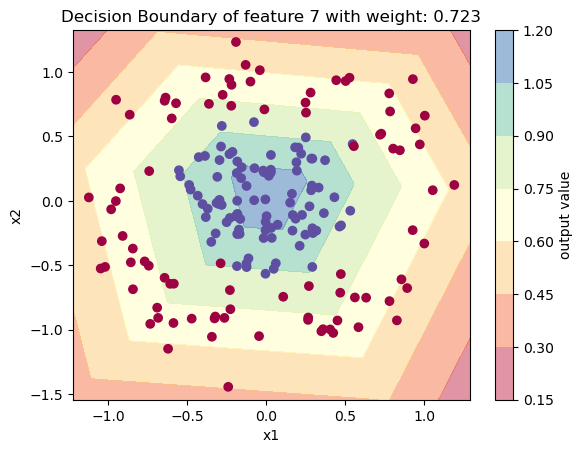

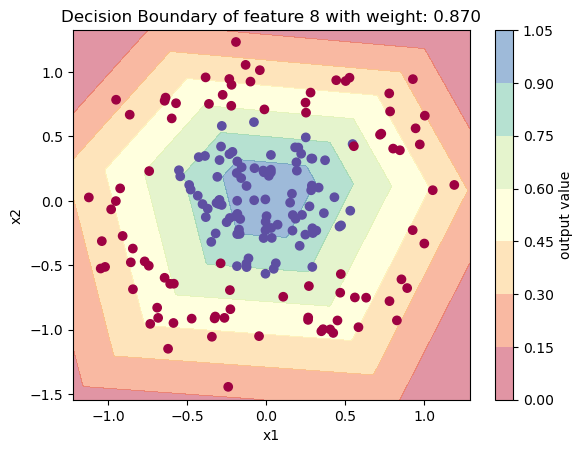

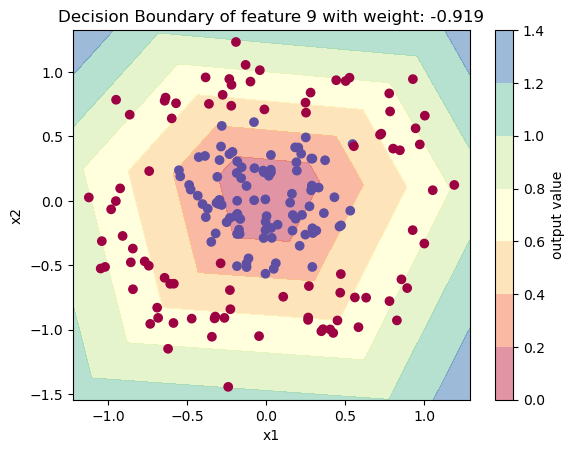

(2, 10) (1, 10)


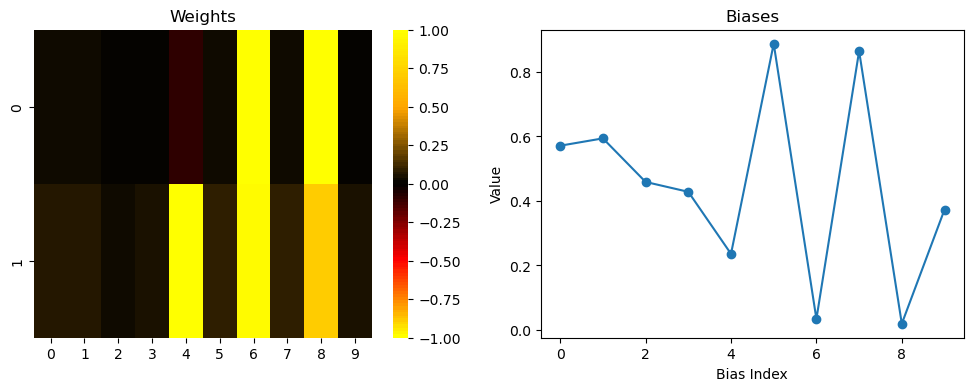

(10, 10) (1, 10)


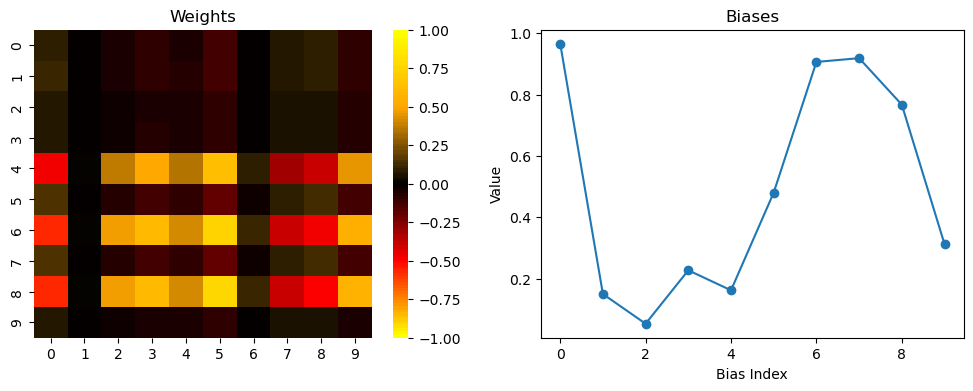

(10, 1) (1, 1)


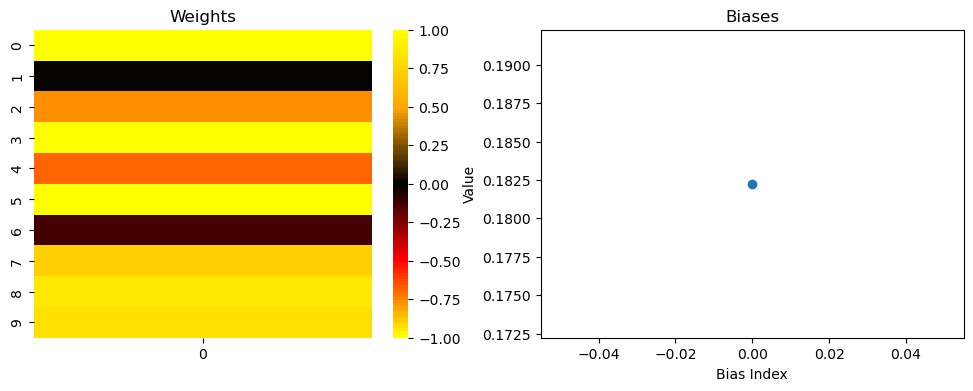

In [22]:
weights_per_model = []
for weight_decay in [0.1, 0.5, 1, 10]:
    model = Network(layers =
        [
            Linear_L2(2, 10, name="input"),
            Activation(ReLU(), name="rely1"),
            Linear_L2(10, 10, name="middle"),
            Activation(ReLU(), name="relu2"),
            Linear_L2(10, 1, name="output"),
            Activation(Sigmoid(), name="sigmoid")
        ]
    )

    criterion = BinaryCrossEntropyLoss()
    X_train, X_test, y_train, y_test = load_data()
    for epoch in range(1, EPOCHS + 1):
        out = model(X_train)
        loss = criterion.loss(y_train, out)
        acc = (np.where(out > 0.5, 1, 0) == y_train).mean()
        error = criterion.gradient(y_train, out)
        model.backward(error)
        model.update(lr=0.001, weight_decay=weight_decay)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss:{np.mean(loss)}, Acc: {acc}")
    plot_decision_boundary_per_feature_last_layer(model, X_test, y_test)
    
    for layer in model.layers:
        visualize_layer(layer, visualize_gradient=False)
    weights_per_model += [np.concatenate([layer.W.reshape(-1) for layer in model.layers if hasattr(layer, 'W')])]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


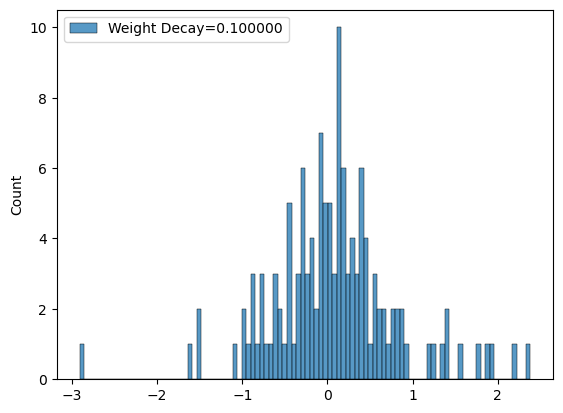

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


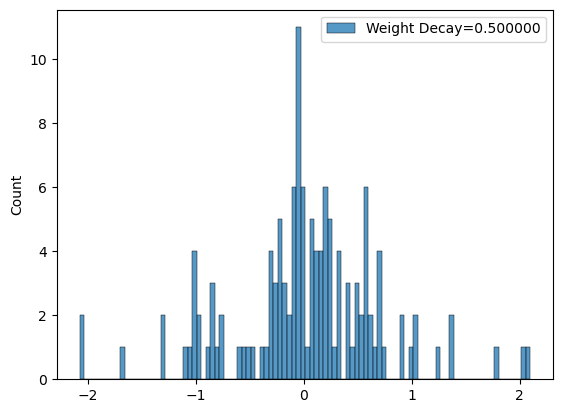

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


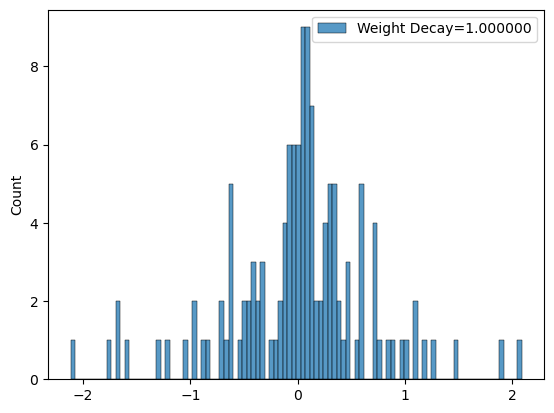

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


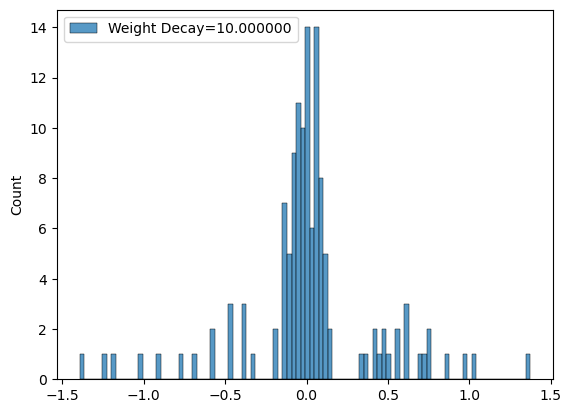

In [23]:
for ws, weight_decay in zip(weights_per_model, [0.1, 0.5, 1, 10]):
    sns.histplot(ws, label='Weight Decay=%f' % weight_decay, bins=100)
    plt.legend()
    plt.show()

Observations:

With higher weight decay, the magnitude of the weights becomes smaller, and the variance decreases as well. While larger weight decay pushes more of the model weights to zero, it severely impact the model's ability to fit the data and lead to severe underfitting and thereby very poor test performance as well.

### Problem 10 (10 points)

Implement sparse decay (L1 regularization) in the `Linear_L1` layer.

Train the network with different sparse decay values and visualize the learned weights for each model using `plot_decision_boundary_per_feature_last_layer`.
Observe how sparse decay promotes sparsity in the learned weights.

In [18]:
class Linear_L1(Linear):
    """
    Linear Layer with L1 regularization.
    """
    def update(self, lr=0.01, weight_decay=0.01):
        # TODO: Apply L1 regularization to update on weights only (not biases)
        if self.gradient_w is not None:
            self.W -= lr * (self.gradient_w + weight_decay * np.sign(self.W))
        if self.gradient_b is not None:
            self.b -= lr * self.gradient_b

Epoch: 100, Loss:0.2789334502153119, Acc: 0.95
Epoch: 200, Loss:0.06156589507588004, Acc: 0.98125
Epoch: 300, Loss:0.045341694071570515, Acc: 0.98125
Epoch: 400, Loss:0.03959382741947067, Acc: 0.98125
Epoch: 500, Loss:0.036668421529297605, Acc: 0.984375
Epoch: 600, Loss:0.03397259179901666, Acc: 0.984375
Epoch: 700, Loss:0.0318446528259408, Acc: 0.984375
Epoch: 800, Loss:0.030932747125817138, Acc: 0.98125
Epoch: 900, Loss:0.030256083492643936, Acc: 0.9875
Epoch: 1000, Loss:0.02960774712982648, Acc: 0.9875


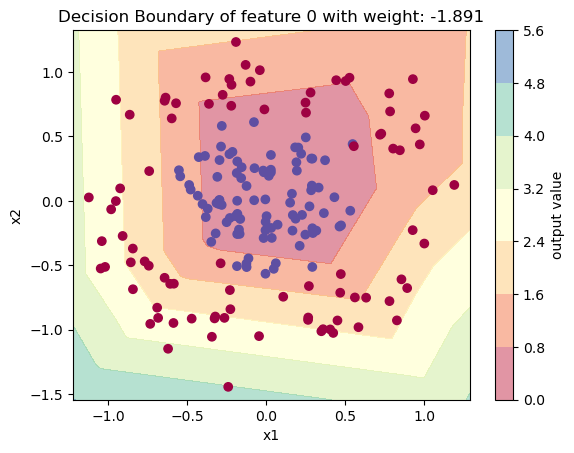

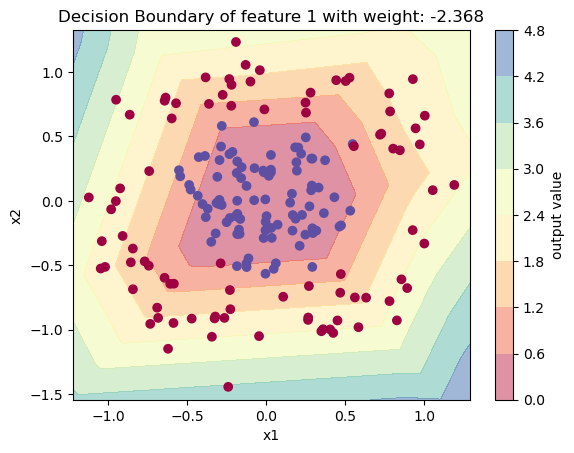

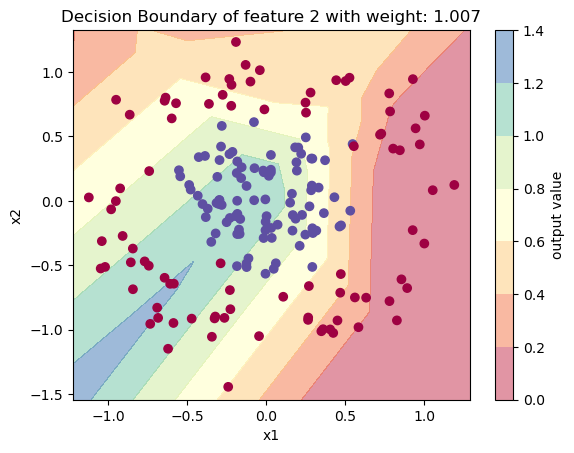

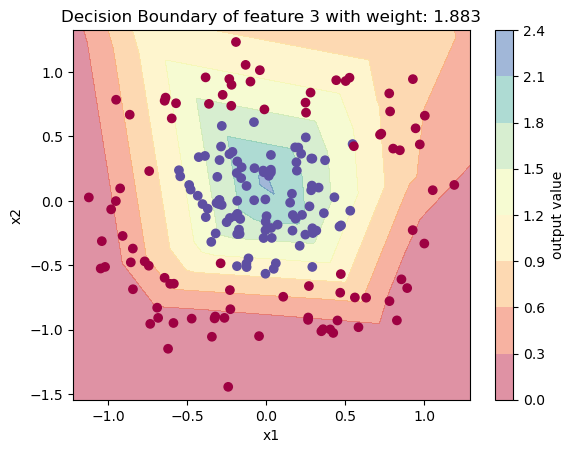

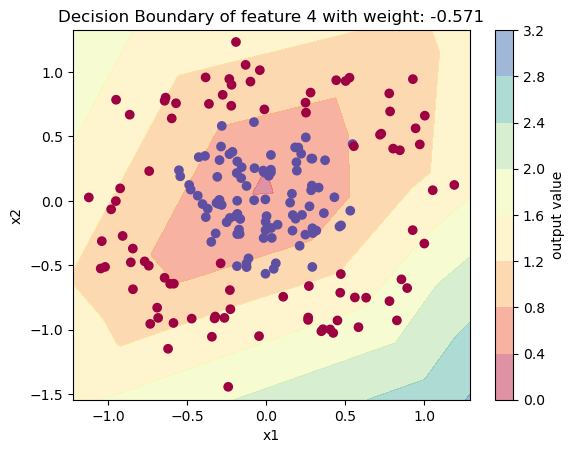

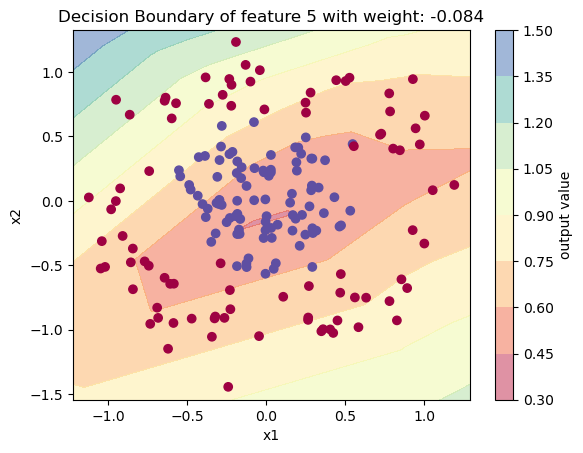

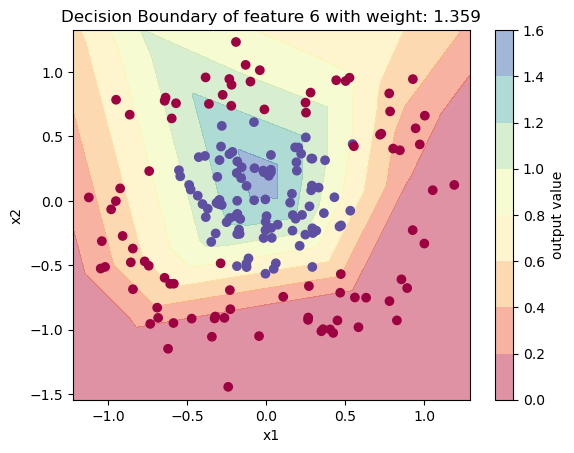

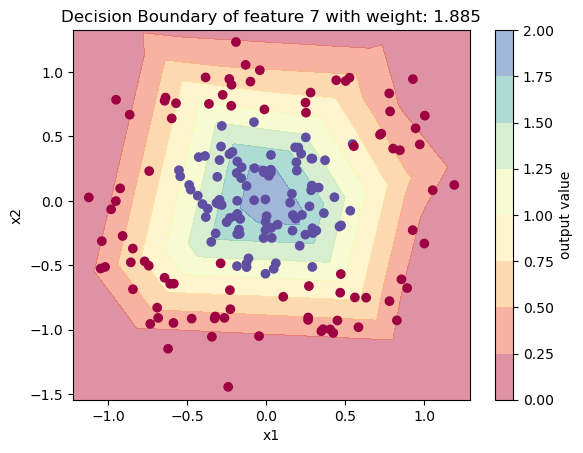

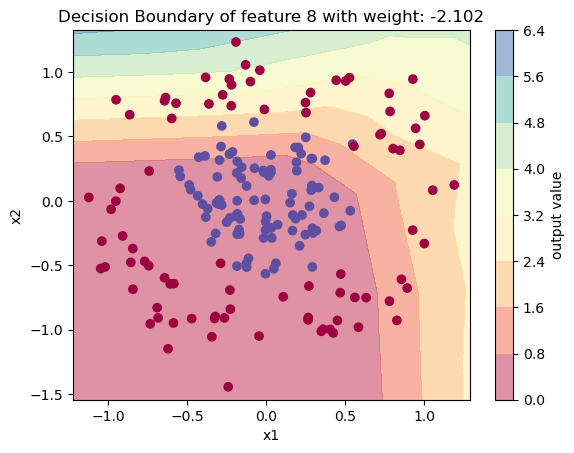

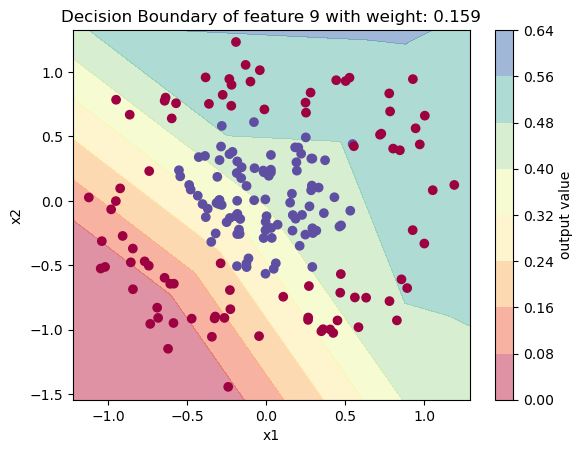

(2, 10) (1, 10)


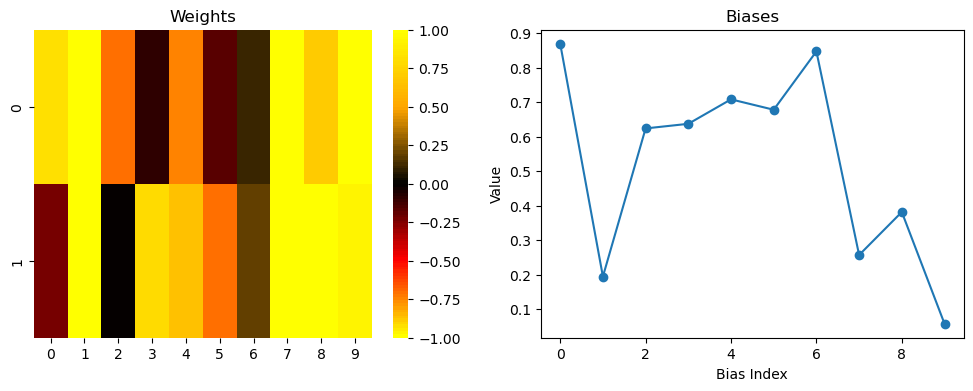

(10, 10) (1, 10)


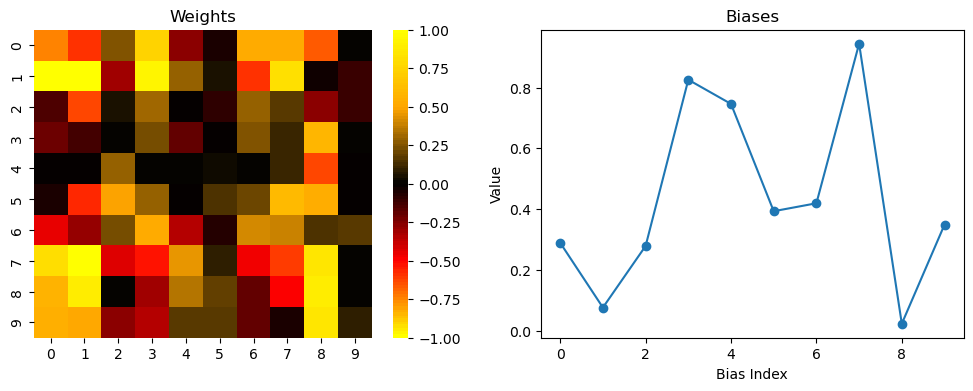

(10, 1) (1, 1)


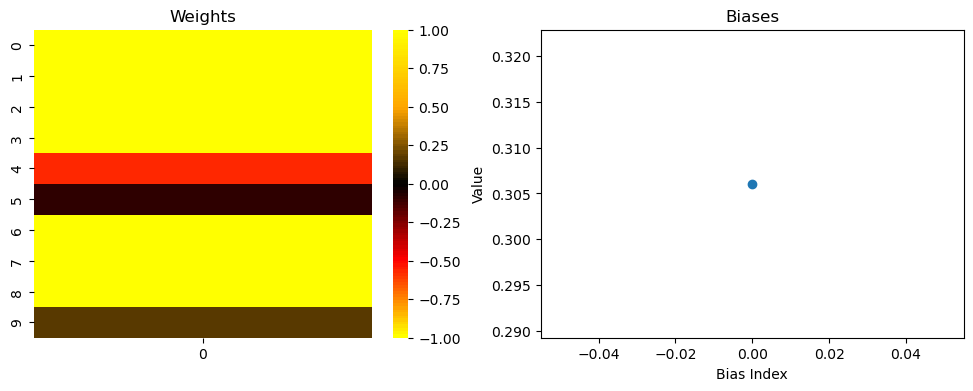

Epoch: 100, Loss:0.4981531083437207, Acc: 0.91875
Epoch: 200, Loss:0.07943598520741264, Acc: 0.9875
Epoch: 300, Loss:0.048272520626680235, Acc: 0.9875
Epoch: 400, Loss:0.04070176190560708, Acc: 0.9875
Epoch: 500, Loss:0.037372408545158484, Acc: 0.9875
Epoch: 600, Loss:0.03548407458037377, Acc: 0.9875
Epoch: 700, Loss:0.03425944428270873, Acc: 0.9875
Epoch: 800, Loss:0.03337160501256078, Acc: 0.9875
Epoch: 900, Loss:0.03269887230472536, Acc: 0.9875
Epoch: 1000, Loss:0.032125116135290906, Acc: 0.9875


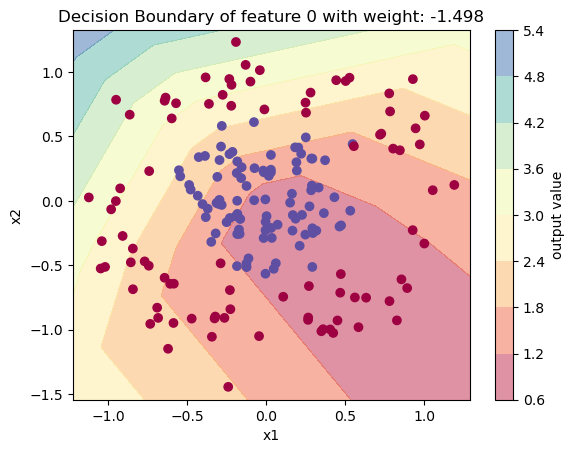

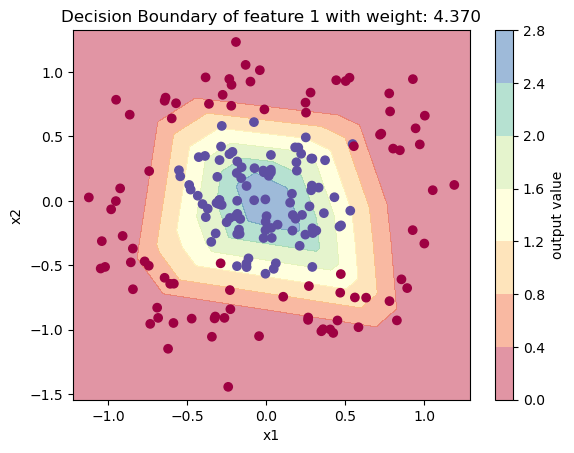

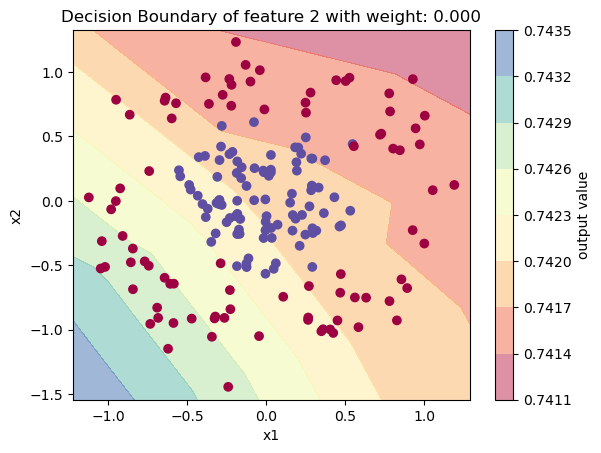

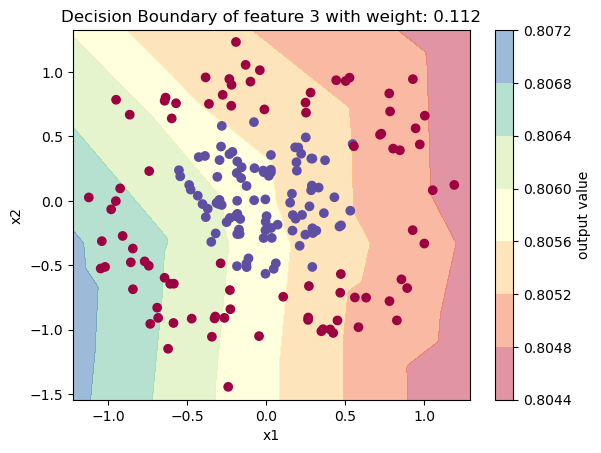

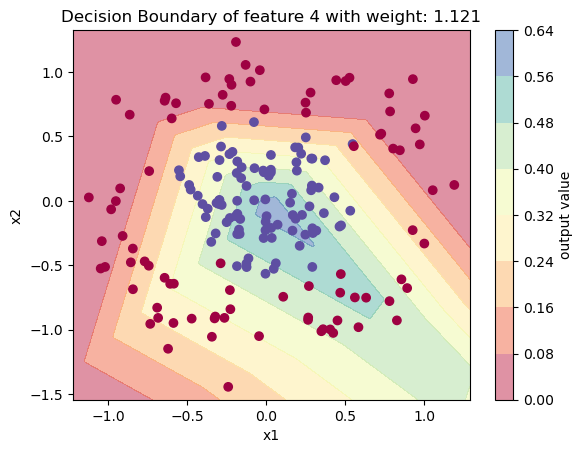

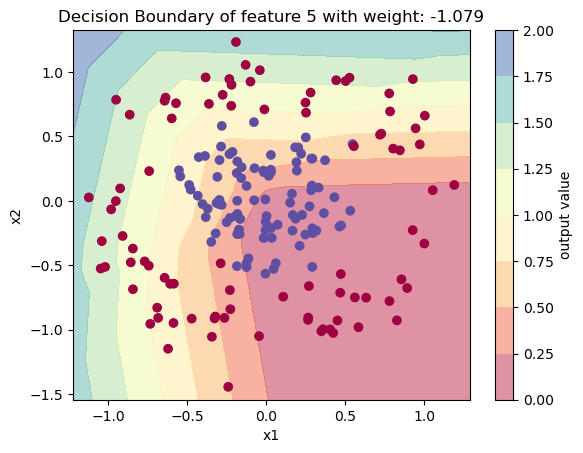

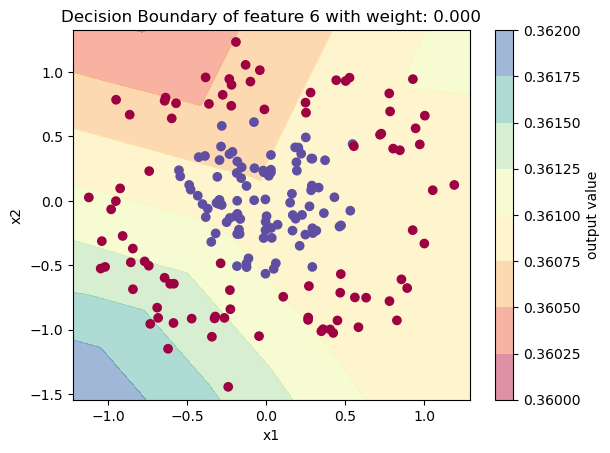

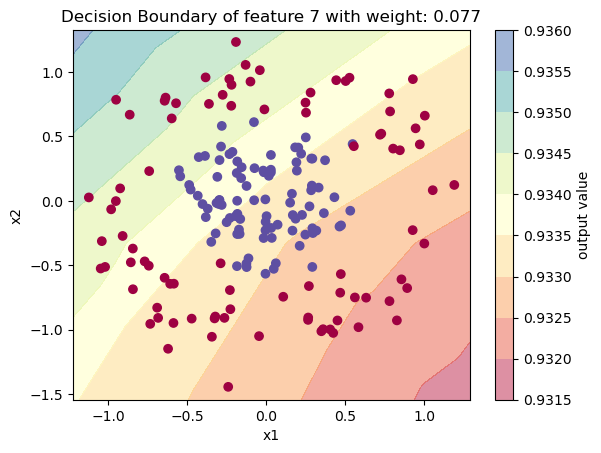

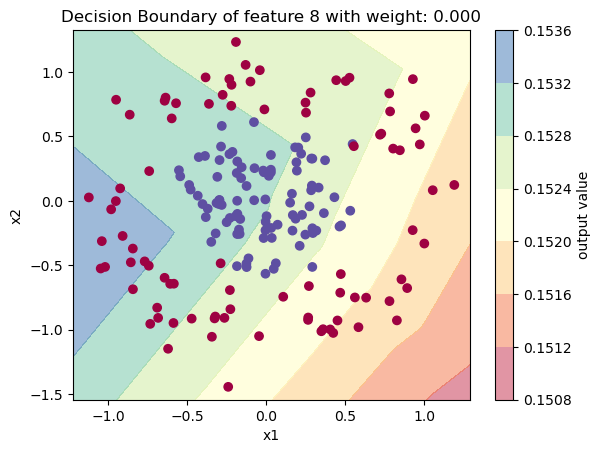

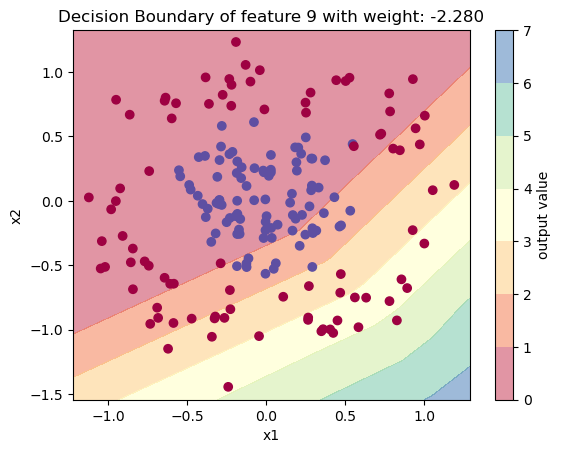

(2, 10) (1, 10)


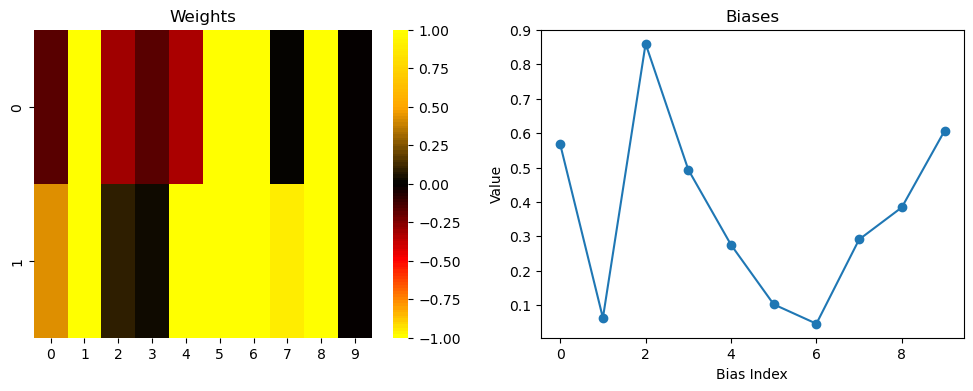

(10, 10) (1, 10)


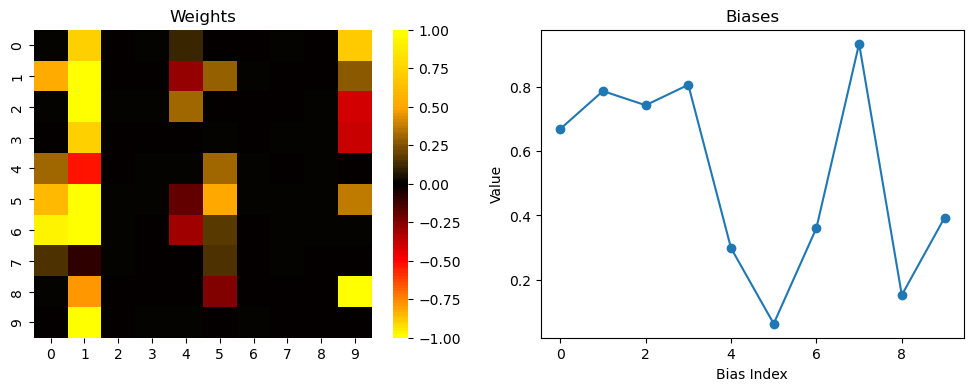

(10, 1) (1, 1)


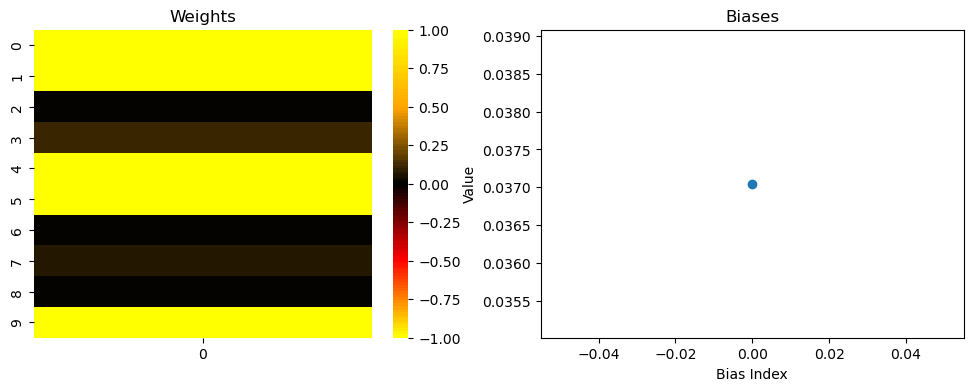

Epoch: 100, Loss:0.4339298499691967, Acc: 0.946875
Epoch: 200, Loss:0.07534807735791864, Acc: 0.984375
Epoch: 300, Loss:0.05649794444714279, Acc: 0.98125
Epoch: 400, Loss:0.05074773106281427, Acc: 0.98125
Epoch: 500, Loss:0.047917886047961475, Acc: 0.98125
Epoch: 600, Loss:0.04608854588718754, Acc: 0.984375
Epoch: 700, Loss:0.04472731822620295, Acc: 0.9875
Epoch: 800, Loss:0.04369341751362434, Acc: 0.9875
Epoch: 900, Loss:0.042986698820018855, Acc: 0.9875
Epoch: 1000, Loss:0.042414098369542214, Acc: 0.9875


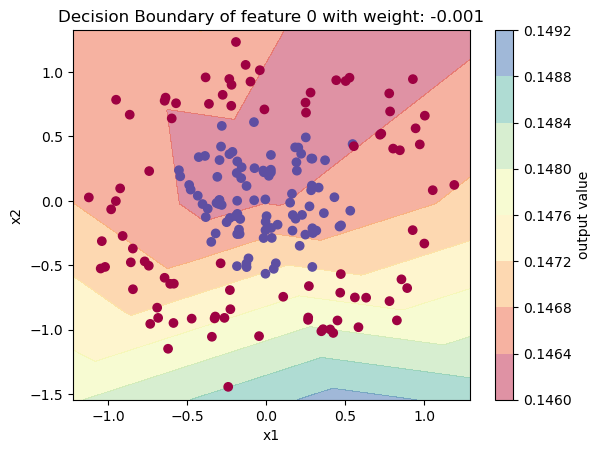

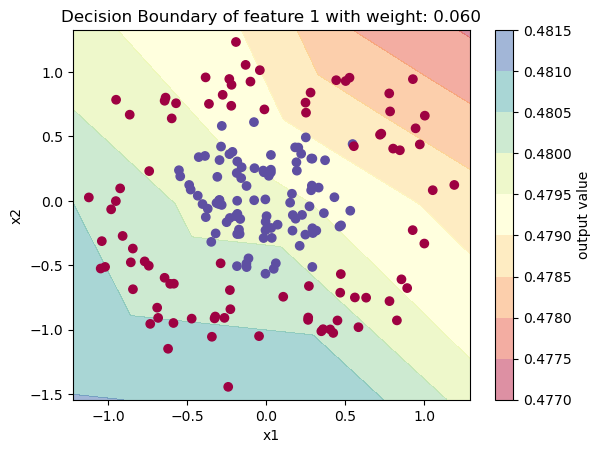

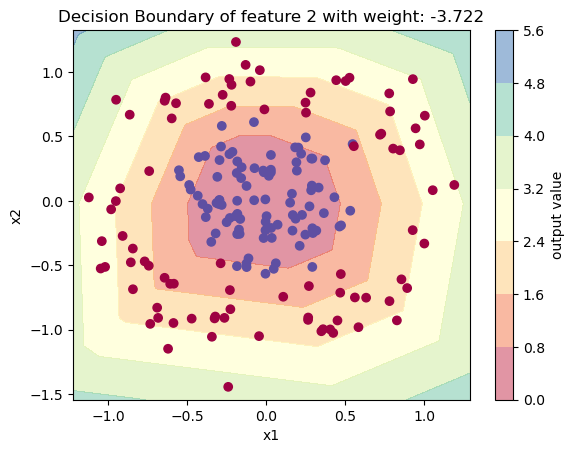

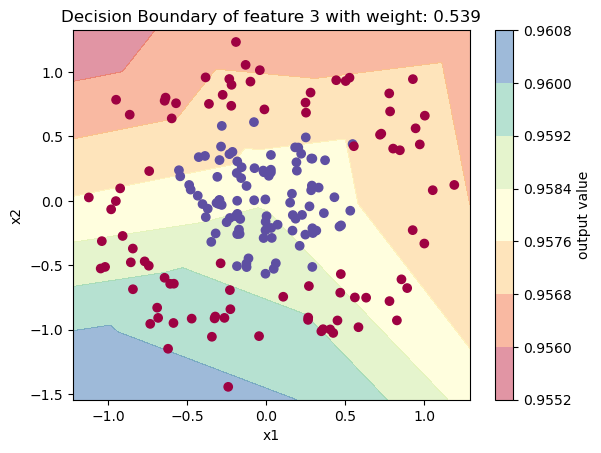

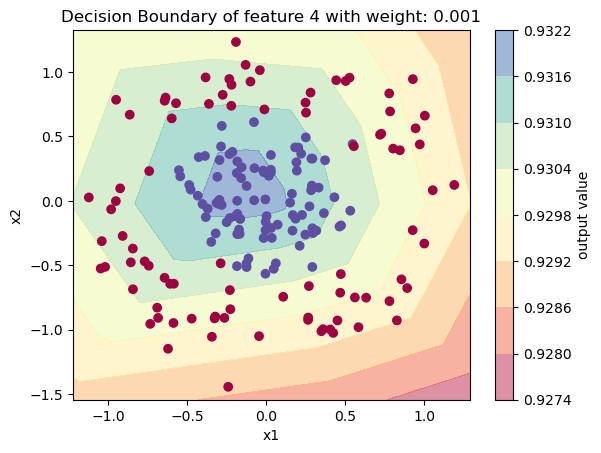

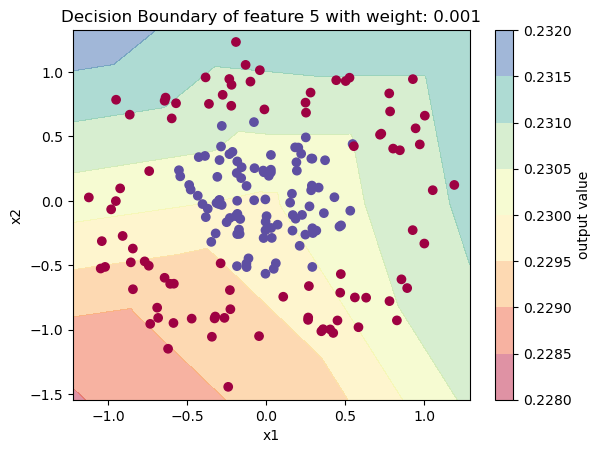

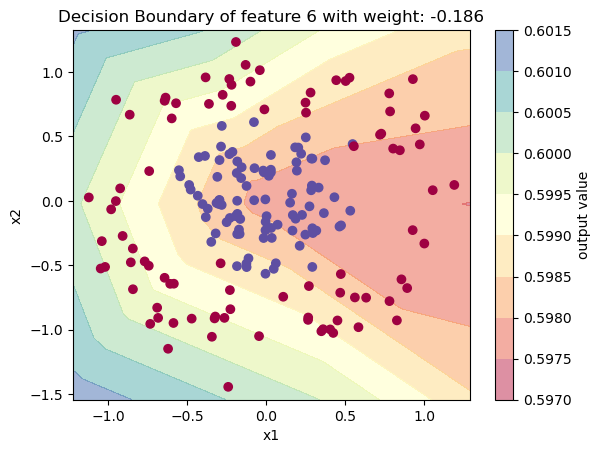

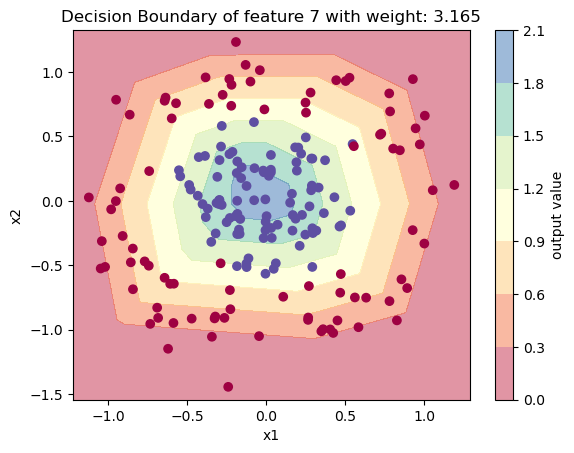

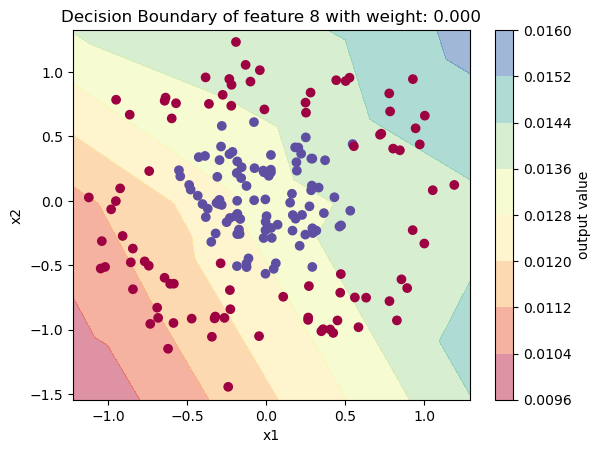

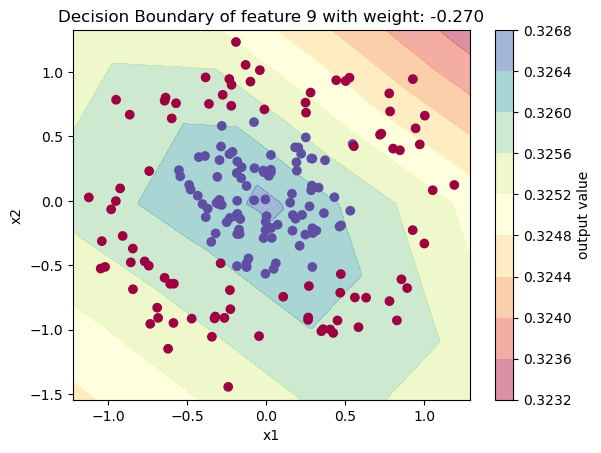

(2, 10) (1, 10)


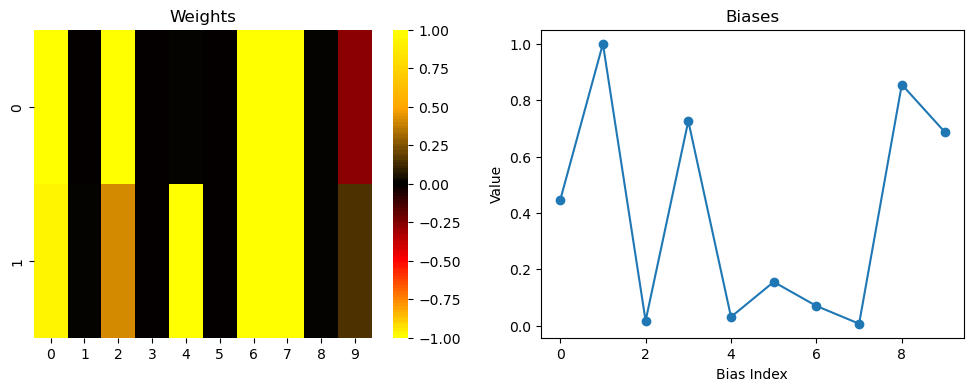

(10, 10) (1, 10)


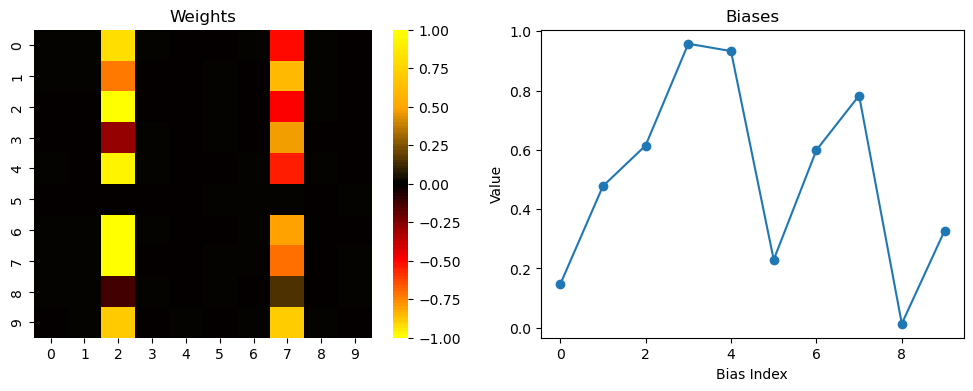

(10, 1) (1, 1)


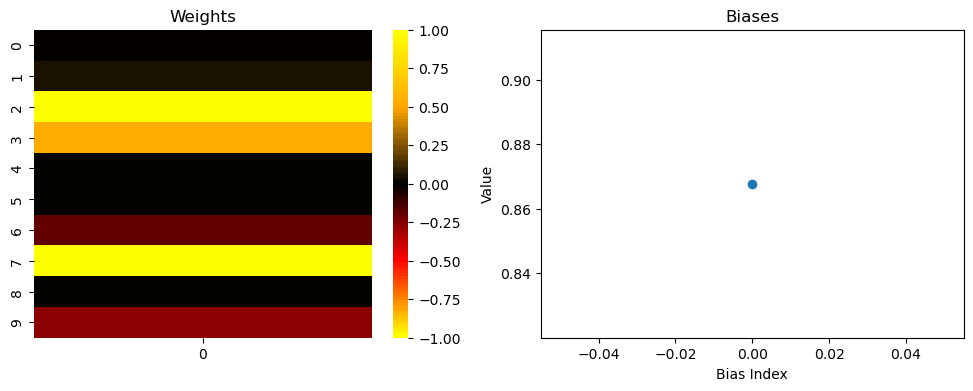

Epoch: 100, Loss:0.6943159874133701, Acc: 0.49375
Epoch: 200, Loss:0.6939888913457815, Acc: 0.49375
Epoch: 300, Loss:0.6943207095866782, Acc: 0.49375
Epoch: 400, Loss:0.6938555763725017, Acc: 0.49375
Epoch: 500, Loss:0.6938928897813141, Acc: 0.49375
Epoch: 600, Loss:0.6941752730909286, Acc: 0.49375
Epoch: 700, Loss:0.694017081128588, Acc: 0.49375
Epoch: 800, Loss:0.6939934532084895, Acc: 0.49375
Epoch: 900, Loss:0.6937322230987818, Acc: 0.49375
Epoch: 1000, Loss:0.6936566615429796, Acc: 0.49375


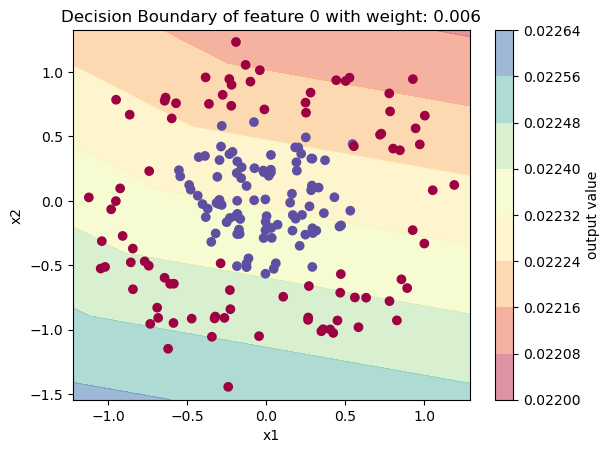

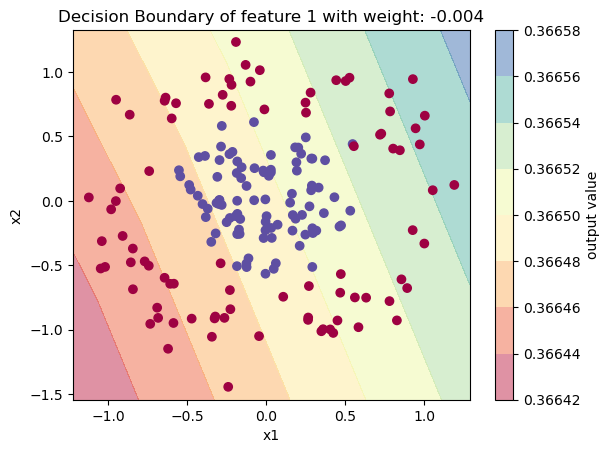

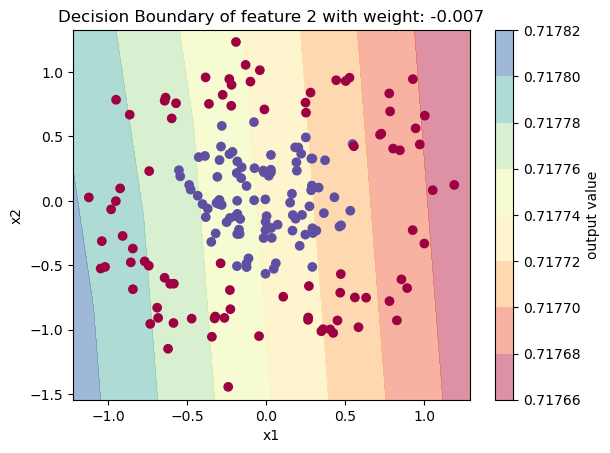

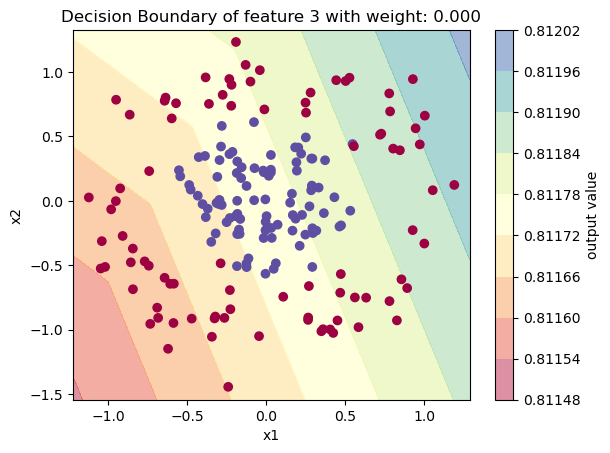

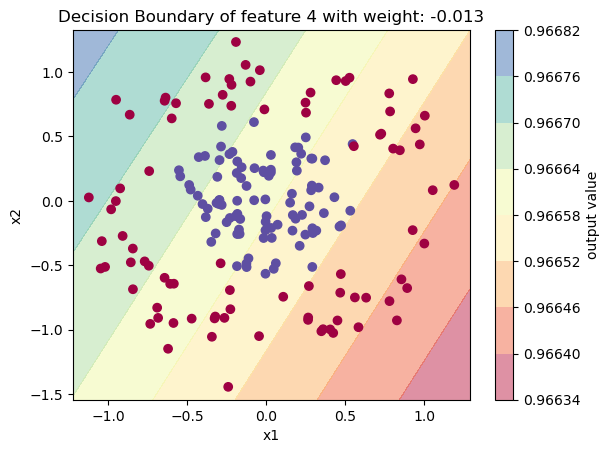

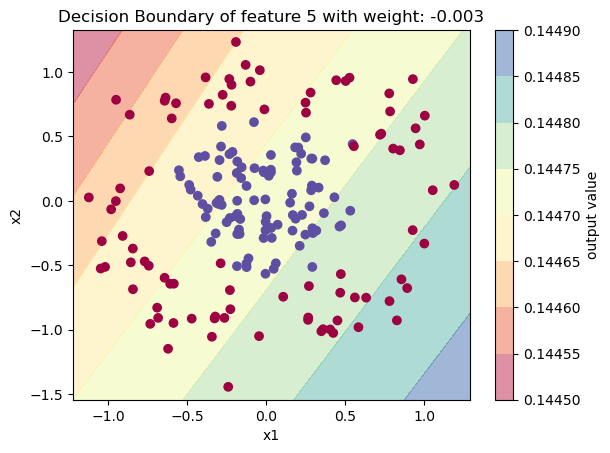

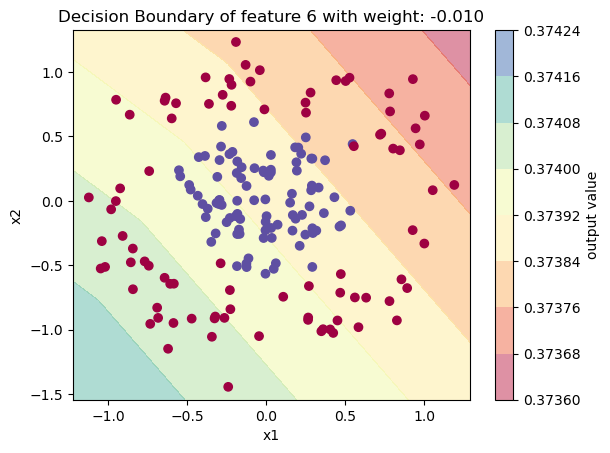

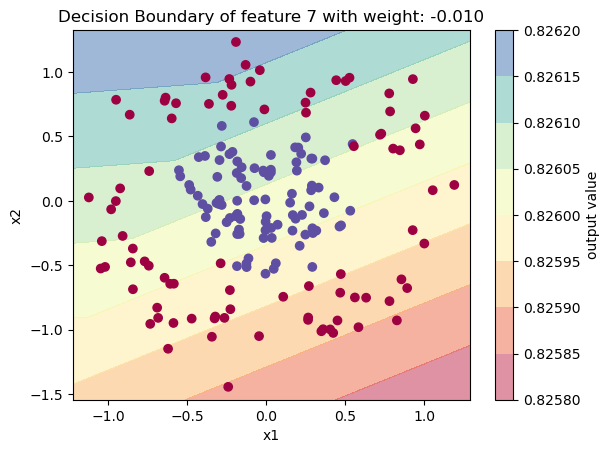

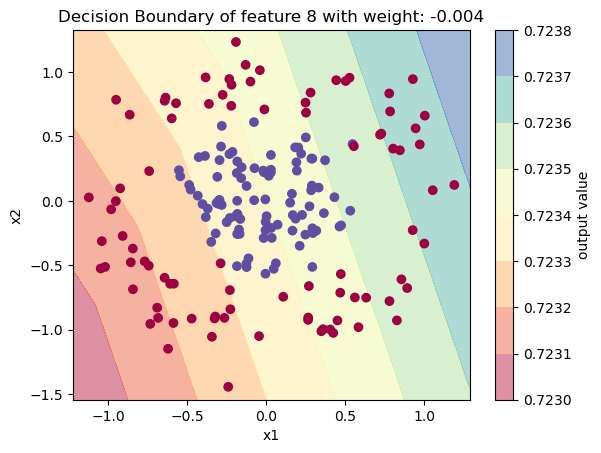

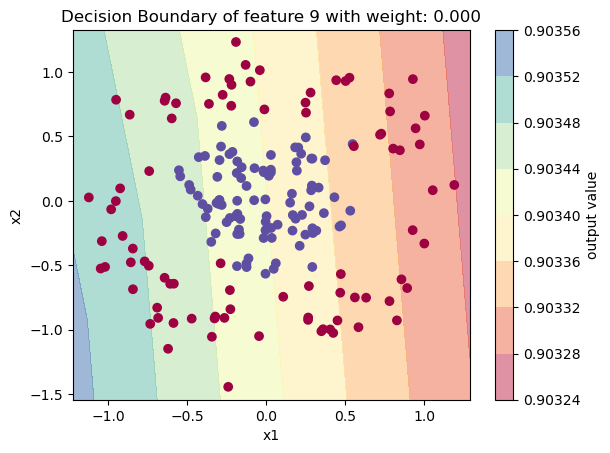

(2, 10) (1, 10)


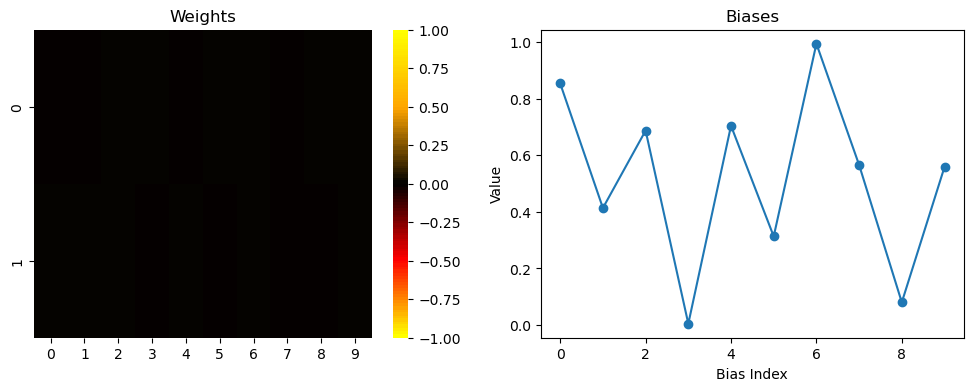

(10, 10) (1, 10)


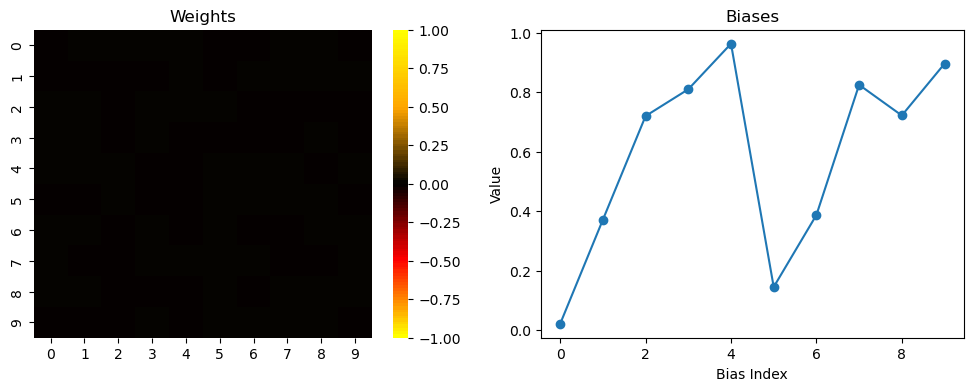

(10, 1) (1, 1)


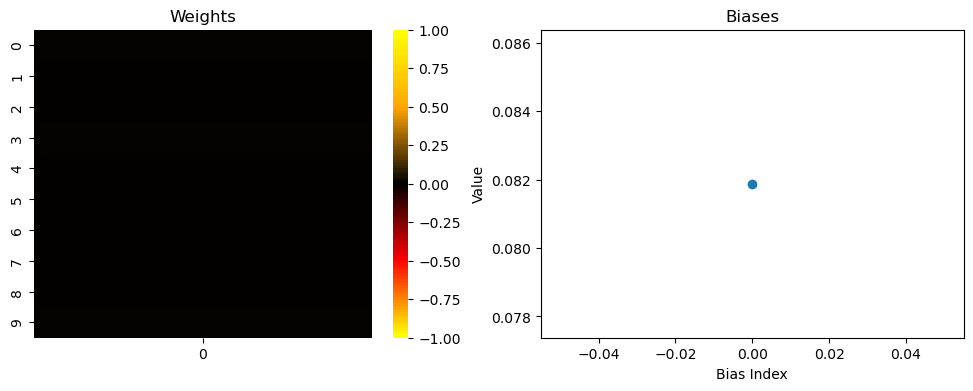

In [19]:
weights_per_model = []
for weight_decay in [0.1, 0.5, 1, 10]:
    model = Network(layers =
        [
            Linear_L1(2, 10, name="input"),
            Activation(ReLU(), name="rely1"),
            Linear_L1(10, 10, name="middle"),
            Activation(ReLU(), name="relu2"),
            Linear_L1(10, 1, name="output"),
            Activation(Sigmoid(), name="sigmoid")
        ]
    )

    criterion = BinaryCrossEntropyLoss()
    X_train, X_test, y_train, y_test = load_data()
    for epoch in range(1, EPOCHS + 1):
        out = model(X_train)
        loss = criterion.loss(y_train, out)
        acc = (np.where(out > 0.5, 1, 0) == y_train).mean()
        error = criterion.gradient(y_train, out)
        model.backward(error)
        model.update(lr=0.001, weight_decay=weight_decay)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss:{np.mean(loss)}, Acc: {acc}")
    plot_decision_boundary_per_feature_last_layer(model, X_test, y_test)
    for layer in model.layers:
        visualize_layer(layer, visualize_gradient=False)
    weights_per_model += [np.concatenate([layer.W.reshape(-1) for layer in model.layers if hasattr(layer, 'W')])]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


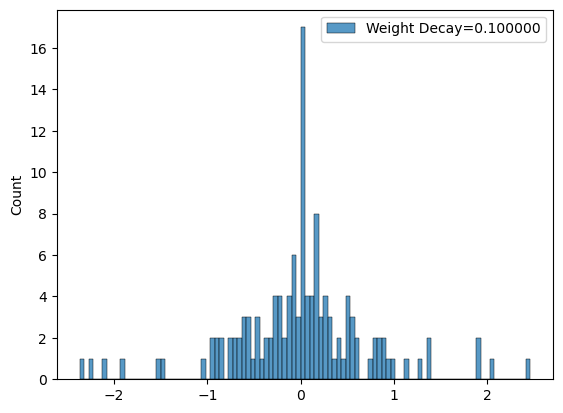

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


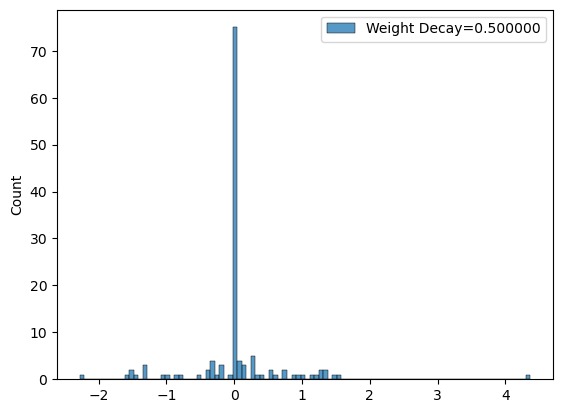

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


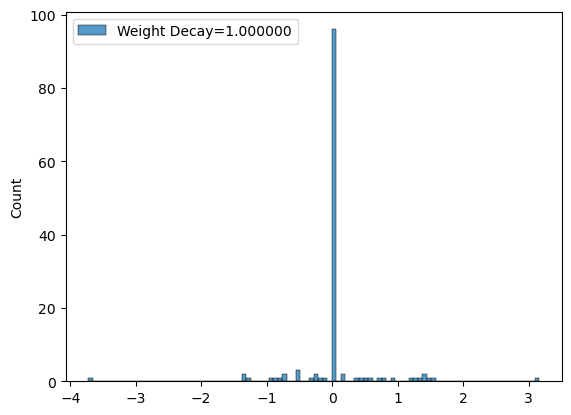

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


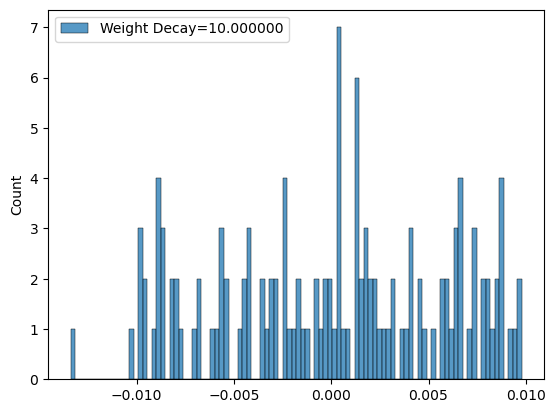

In [20]:
for ws, weight_decay in zip(weights_per_model, [0.1, 0.5, 1, 10]):
    sns.histplot(ws, label='Weight Decay=%f' % weight_decay, bins=100)
    plt.legend()
    plt.show()

Observations:

With larger L1 weight decay, the model becomes highly sparse and pushed most of the weight to absolute zero. L1 decay is more effective in enforcing sparsity in weights than L2 decay. It helps use fewer features for classification. However, with the largest weight decay value of 10, we observe clear training instability which has detrimental results for both training and test error values.